In [657]:
################
# INTRODUCTION #
################

# Import necessary libraries.
# Note: Import these libraries onto your virtual environment for this project if you haven't already.
import os
import re
import math
import dash
import time
import h5py
import random
import shutil
import warnings
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display
from PIL import Image
from scipy.stats import pearsonr
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import necessary files/functions.

# Set the correct options.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [176]:
#############
# CONSTANTS #
#############

EVENT_STRS = {
    0: 'Address',
    1: 'Toe_Up',
    2: 'Mid_Backswing',
    3: 'Top',
    4: 'Mid_Downswing',
    5: 'Impact',
    6: 'Mid_Follow_Through',
    7: 'Finish'
}

LM_STRS = {
    0: 'Nose',
    1: 'Left_Eye_Inner',
    2: 'Left_Eye',
    3: 'Left_Eye_Outer',
    4: 'Right_Eye_Inner',
    5: 'Right_Eye',
    6: 'Right_Eye_Outer',
    7: 'Left_Ear',
    8: 'Right_Ear',
    9: 'Mouth_Left',
    10: 'Mouth_Right',
    11: 'Left_Shoulder',
    12: 'Right_Shoulder',
    13: 'Left_Elbow',
    14: 'Right_Elbow',
    15: 'Left_Wrist',
    16: 'Right_Wrist',
    17: 'Left_Pinky',
    18: 'Right_Pinky',
    19: 'Left_Index',
    20: 'Right_Index',
    21: 'Left_Thumb',
    22: 'Right_Thumb',
    23: 'Left_Hip',
    24: 'Right_Hip',
    25: 'Left_Knee',
    26: 'Right_Knee',
    27: 'Left_Ankle',
    28: 'Right_Ankle',
    29: 'Left_Heel',
    30: 'Right_Heel',
    31: 'Left_Foot_Index',
    32: 'Right_Foot_Index'
}

XYZ = ['x', 'y', 'z']
# XYZ = ['x', 'y']

DISTINCT_COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255),
    (255, 255, 0), (255, 0, 255), (0, 255, 255),
    (128, 0, 0), (0, 128, 0), (0, 0, 128),
    (128, 128, 0), (128, 0, 128), (0, 128, 128),
    (64, 0, 0), (0, 64, 0), (0, 0, 64),
    (64, 64, 0), (64, 0, 64), (0, 64, 64),
    (192, 0, 0), (0, 192, 0), (0, 0, 192),
    (192, 192, 0), (192, 0, 192), (0, 192, 192),
    (128, 128, 128), (255, 128, 0), (255, 0, 128),
    (128, 255, 0), (0, 255, 128), (128, 0, 255),
    (0, 128, 255), (255, 128, 128), (128, 255, 128)]


In [ ]:
#############
# FUNCTIONS #
#############

# Func: Convert 'Club_Type_String' to 'Club_Type_Float'.
def ct_str_to_ct_float(ct_str):
    if ct_str == 'Driver' or ct_str == '1 - Driver':
        return 1.0
    if ct_str == '3 Wood' or ct_str == '3 - Fairway Wood' or ct_str == 'Fairway Wood':
        return 1.3
    if ct_str == '5 Wood':
        return 1.5
    if ct_str == '3 Hybrid':
        return 2.1
    if ct_str == '4 Hybrid':
        return 2.2
    if ct_str == '3 Iron':
        return 3.0
    if ct_str == '4 Iron':
        return 4.0
    if ct_str == '5 Iron':
        return 5.0
    if ct_str == '6 Iron':
        return 6.0
    if ct_str == '7 Iron':
        return 7.0
    if ct_str == '8 Iron':
        return 8.0
    if ct_str == '9 Iron':
        return 9.0
    if ct_str == 'Pitching Wedge':
        return 10.0
    if ct_str == 'Lob Wedge':
        return 11.0
    if ct_str == 'Sand Wedge':
        return 11.5
    if ct_str == '54Â° Wedge':
        return 12.0
    if ct_str == '58Â° Wedge':
        return 13.0
    return 0.0

# Func: Convert 'Club_Type_Float' to 'Club_Type_String'.
def ct_float_to_ct_str(ct_float):
    if ct_float == 1.0:
        return 'Driver'
    if ct_float == 1.3:
        return '3 Wood'
    if ct_float == 1.5:
        return '5 Wood'
    if ct_float == 2.1:
        return '3 Hybrid'
    if ct_float == 2.2:
        return '4 Hybrid'
    if ct_float == 3.0:
        return '3 Iron'
    if ct_float == 4.0:
        return '4 Iron'
    if ct_float == 5.0:
        return '5 Iron'
    if ct_float == 6.0:
        return '6 Iron'
    if ct_float == 7.0:
        return '7 Iron'
    if ct_float == 8.0:
        return '8 Iron'
    if ct_float == 9.0:
        return '9 Iron'
    if ct_float == 10.0:
        return 'Pitching Wedge'
    if ct_float == 11.0:
        return 'Lob Wedge'
    if ct_float == 11.5:
        return 'Sand Wedge'
    if ct_float == 12.0:
        return '54Â° Wedge'
    if ct_float == 13.0:
        return '58Â° Wedge'
    return 'None'

# Func: Round floats correctly.
def custom_round(number, decimal_places):
    return int(number * (10 ** decimal_places) + 0.5) / (10 ** decimal_places)

# Func: Determine whether the given features are multicollinear with one another.
def is_multicollinear(df):
    vif_df = pd.DataFrame()
    vif_df['Feature'] = df.columns
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    vif_df['VIF'] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    warnings.filterwarnings("default", category=RuntimeWarning)
    vifs = vif_df['VIF'].tolist()
    for vif in vifs:
        if (math.isinf(vif) or vif > 10):
            return True
    return False

# Func: Determine the feature that has the highest correlation sum.
def highest_corr_sum_feature(df, x_labels):
    corr_sum_df = pd.DataFrame()
    corr_sum_df['Feature'] = df.columns
    corr_sum_df.set_index('Feature', inplace=True)
    corr_sum_df['Corr_Sum'] = 0
    for x_label in x_labels:
        summation = 0
        for x_label_1 in x_labels:
            x = df[x_label].values
            y = df[x_label_1].values
            summation += abs(np.corrcoef(x, y)[0, 1])
        corr_sum_df.loc[x_label, 'Corr_Sum'] = summation
    highest_corr_sum_str = ''
    highest_corr_sum_float = 0
    corr_sums = corr_sum_df['Corr_Sum'].tolist()
    for i in range(0, len(corr_sums)):
        if corr_sums[i] > highest_corr_sum_float:
            highest_corr_sum_float = corr_sums[i]
            highest_corr_sum_str = x_labels[i]
    return highest_corr_sum_str

# Func: Determine the corresponding lm_str from lm_int.
def lm_int_to_lm_str(lm_int):
    return LM_STRS[lm_int]

# Func: Rescale the frame.
def rescale_frame(frame, scale):
    width = int(frame.shape[1] * scale)
    height = int(frame.shape[0] * scale)
    dimensions = (width, height)
    return cv.resize(frame, dimensions, interpolation=cv.INTER_AREA)

# Func: Calculate the angle between 3 landmarks.
def angle_btn_3_lms(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    angle_rad = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle_deg = np.abs(radians*180.0/np.pi)
    if angle_deg > 180.0:
        angle_deg = 360 - angle_deg
    return angle_deg

# Func9: Remove the starting and ending brackets in a string.
def remove_brackets(list_str):
    return list_str[1:len(list_str)-1]

# Func10: Count the amount of files in a directory.
def count_files(directory_path):
    file_count = 0
    for _, _, files in os.walk(directory_path):
        file_count += len(files)
    return file_count

# Func11: Delete all files in a directory.
def delete_files(directory_path):
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)
            
# Func: Find the color of a specific pixel from a frame.
def get_pixel_color(frame, x, y):
    color = frame[y, x]
    color = color[::-1]
    return color

#Func: Round values to just 0.0, 0.2, 0.4, 0.6, 0.8, or 1.0.
def round_to_fifths(value):
    if value > 0.8:
        return 1.0
    elif value > 0.6:
        return 0.8
    elif value > 0.4:
        return 0.6
    elif value > 0.2:
        return 0.4
    elif value > 0:
        return 0.2
    return 0.0

# Func: Crop and rescale the frame to preprocess the video frames.
def crop_and_rescale_frame(image, height_start, height_end, width_center):
    height_start = int(height_start)
    height_end = int(height_end)
    width_center = int(width_center)
    height = height_end - height_start
    width = height
    y_start = max(0, height_start)
    y_end = min(image.shape[0], height_end)
    x_start = max(0, width_center - width // 2)
    x_end = min(image.shape[1], width_center + width // 2)
    cropped_image = image[y_start:y_end, x_start:x_end]
    blank_image = np.zeros((height, width, 3), dtype=np.uint8)
    y_offset = max(0, (height - cropped_image.shape[0]) // 2)
    x_offset = max(0, (width - cropped_image.shape[1]) // 2)
    blank_image[y_offset:y_offset+cropped_image.shape[0], x_offset:x_offset+cropped_image.shape[1]] = cropped_image
    resized_image = cv.resize(blank_image, (160, 160))
    return resized_image

def crop_frame(image, height_start, height_end, width_center):
    height_start = int(height_start)
    height_end = int(height_end)
    width_center = int(width_center)
    height = height_end - height_start
    width = height
    y_start = max(0, height_start)
    y_end = min(image.shape[0], height_end)
    x_start = max(0, width_center - width // 2)
    x_end = min(image.shape[1], width_center + width // 2)
    cropped_image = image[y_start:y_end, x_start:x_end]
    blank_image = np.zeros((height, width, 3), dtype=np.uint8)
    y_offset = max(0, (height - cropped_image.shape[0]) // 2)
    x_offset = max(0, (width - cropped_image.shape[1]) // 2)
    blank_image[y_offset:y_offset+cropped_image.shape[0], x_offset:x_offset+cropped_image.shape[1]] = cropped_image
    return blank_image

# Func: Show the video frame at an exact frame number.
def show_video_frame(video_path, frame_number):
    cap = cv.VideoCapture(video_path)
    cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)
    
    ret, frame = cap.read()
    if ret:
        cv.imshow('Video Frame', frame)
        cv.waitKey(0)
    cap.release()
    cv.destroyAllWindows()
    cv.waitKey(1)

# Func: Throw out outliers based on moving average.
def throw_outliers_moving_avg(lms_df):
    global XYZ
    batch_size = 50
    lms_df.insert(loc=0, column='Flagged', value=False)
    flagged_list = []
    moving_avgs_df = pd.DataFrame()
    moving_avgs_df['Frame'] = lms_df.index.tolist()
    moving_avgs_df.set_index('Frame', inplace=True)
    counter = 0
    x = lms_df.index.tolist()
    for lm_int in mp_pose.PoseLandmark:
        lm_str = lm_int_to_lm_str(lm_int)
        for char in XYZ:
            column_label = lm_str + '_' + char.capitalize() + '_Position'
            moving_avgs_df[column_label] = 0
            lm_coords = lms_df[column_label].tolist()
            lm_coords_sliced = lm_coords[0:batch_size]
            moving_avg = np.mean(lm_coords_sliced)
            moving_std = np.std(lm_coords_sliced)
            threshold_min = moving_avg - moving_std * 2
            threshold_max = moving_avg + moving_std * 2
            for i in range(0, batch_size):
                moving_avgs_df.iloc[i, counter] = moving_avg
                lm_coord = lm_coords[i]
                abs_diff = abs(moving_avg - lm_coords[i])
                abs_sum = abs(moving_avg + lm_coords[i])
                percentage_diff = abs(abs_diff / (abs_sum / 2))
                if percentage_diff > 15:
                    flagged_list.append(i)
                    # lm_coords[i] = moving_avg
                    lm_coords_sliced = lm_coords[0:batch_size]
                    moving_avg = np.mean(lm_coords_sliced)
                    moving_std = np.std(lm_coords_sliced)
                    threshold_min = moving_avg - moving_std * 2
                    threshold_max = moving_avg + moving_std * 2
            for i in range(batch_size, len(lm_coords)):
                lm_coord = lm_coords[i]
                lm_coords_sliced = lm_coords[i-batch_size:i]
                moving_avg = np.mean(lm_coords_sliced)
                moving_avgs_df.iloc[i, counter] = moving_avg
                moving_std = np.std(lm_coords_sliced)
                threshold_min = moving_avg - moving_std * 2
                threshold_max = moving_avg + moving_std * 2
                abs_diff = abs(moving_avg - lm_coords[i])
                abs_sum = abs(moving_avg + lm_coords[i])
                percentage_diff = abs(abs_diff / (abs_sum / 2))
                if percentage_diff > 15:
                    flagged_list.append(i)
                    # lm_coords[i] = moving_avg
            counter += 1
    flagged_list = set(flagged_list)
    for index in flagged_list:
        lms_df.iloc[index, 0] = True
    lms_modified_df = lms_df[~lms_df['Flagged']]
    return lms_df, lms_modified_df, moving_avgs_df

# Func: Throw out outliers using line of best fit.
def throw_outliers_best_fit(lms_df):
    global mp_pose
    global XYZ
    lms_df.insert(loc=0, column='Flagged', value=False)
    flagged_list = []
    # lms_df.insert(loc=0, column='Flagged', value=False)
    # flagged_list = []
    # lms_best_fit_df = pd.DataFrame()
    # lms_best_fit_df['Event_And_Axis'] = ''
    # lms_best_fit_df.set_index('Event_And_Axis', inplace=True)
    x = lms_df.index.tolist()
    for lm_int in mp_pose.PoseLandmark:
        lm_str = lm_int_to_lm_str(lm_int)
        for char in XYZ:
            row_label = lm_str + '_' + char.capitalize() + '_Position'
            y = lms_df[row_label].tolist()
            degree = 18
            coefficients = np.polyfit(x, y, degree)
            predicted_values = np.polyval(coefficients, x)
            column_label = lm_str + '_' + char.capitalize() + '_Position_Predicted'
            lms_df = lms_df.copy()
            lms_df[column_label] = predicted_values
            # column_label = 'Degree_' + str(i)
            # correlation_and_p_value = pearsonr(y, predicted_values)
            # lms_best_fit_df.at[row_label, column_label] = 'Corr: ' + str(custom_round(correlation_and_p_value[0], 3)) + ', P-value: ' + str(custom_round(correlation_and_p_value[1], 3))
            if char == 'z':
                pass
            else:
                for i in range(0, len(x)):
                    abs_diff = abs(predicted_values[i] - y[i])
                    abs_sum = abs(predicted_values[i] + y[i])
                    percentage_diff = abs(abs_diff / (abs_sum / 2))
                    if percentage_diff > 0.5:
                        print(column_label, x[i], percentage_diff)
                        flagged_list.append(i)
    flagged_list = set(flagged_list)
    for index in flagged_list:
        lms_df.iloc[index, 0] = True
    lms_modified_df = lms_df[~lms_df['Flagged']]
    flagged_list = []
    x = lms_modified_df.index.tolist()
    for lm_int in mp_pose.PoseLandmark:
        lm_str = lm_int_to_lm_str(lm_int)
        for char in XYZ:
            row_label = lm_str + '_' + char.capitalize() + '_Position'
            y = lms_modified_df[row_label].tolist()
            degree = 18
            coefficients = np.polyfit(x, y, degree)
            predicted_values = np.polyval(coefficients, x)
            column_label = lm_str + '_' + char.capitalize() + '_Position_Predicted_2'
            lms_modified_2

In [940]:
#############
# FUNCTIONS #
#############

# Func: Convert 'Club_Type_String' to 'Club_Type_Float'.
def ct_str_to_ct_float(ct_str):
    if ct_str == 'Driver' or ct_str == '1 - Driver':
        return 1.0
    if ct_str == '3 Wood' or ct_str == '3 - Fairway Wood' or ct_str == 'Fairway Wood':
        return 1.3
    if ct_str == '5 Wood':
        return 1.5
    if ct_str == '3 Hybrid':
        return 2.1
    if ct_str == '4 Hybrid':
        return 2.2
    if ct_str == '3 Iron':
        return 3.0
    if ct_str == '4 Iron':
        return 4.0
    if ct_str == '5 Iron':
        return 5.0
    if ct_str == '6 Iron':
        return 6.0
    if ct_str == '7 Iron':
        return 7.0
    if ct_str == '8 Iron':
        return 8.0
    if ct_str == '9 Iron':
        return 9.0
    if ct_str == 'Pitching Wedge':
        return 10.0
    if ct_str == 'Lob Wedge':
        return 11.0
    if ct_str == 'Sand Wedge':
        return 11.5
    if ct_str == '54Â° Wedge':
        return 12.0
    if ct_str == '58Â° Wedge':
        return 13.0
    return 0.0

# Func: Convert 'Club_Type_Float' to 'Club_Type_String'.
def ct_float_to_ct_str(ct_float):
    if ct_float == 1.0:
        return 'Driver'
    if ct_float == 1.3:
        return '3 Wood'
    if ct_float == 1.5:
        return '5 Wood'
    if ct_float == 2.1:
        return '3 Hybrid'
    if ct_float == 2.2:
        return '4 Hybrid'
    if ct_float == 3.0:
        return '3 Iron'
    if ct_float == 4.0:
        return '4 Iron'
    if ct_float == 5.0:
        return '5 Iron'
    if ct_float == 6.0:
        return '6 Iron'
    if ct_float == 7.0:
        return '7 Iron'
    if ct_float == 8.0:
        return '8 Iron'
    if ct_float == 9.0:
        return '9 Iron'
    if ct_float == 10.0:
        return 'Pitching Wedge'
    if ct_float == 11.0:
        return 'Lob Wedge'
    if ct_float == 11.5:
        return 'Sand Wedge'
    if ct_float == 12.0:
        return '54Â° Wedge'
    if ct_float == 13.0:
        return '58Â° Wedge'
    return 'None'

# Func: Round floats correctly.
def custom_round(number, decimal_places):
    return int(number * (10 ** decimal_places) + 0.5) / (10 ** decimal_places)

# Func: Determine whether the given features are multicollinear with one another.
def is_multicollinear(df):
    vif_df = pd.DataFrame()
    vif_df['Feature'] = df.columns
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    vif_df['VIF'] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    warnings.filterwarnings("default", category=RuntimeWarning)
    vifs = vif_df['VIF'].tolist()
    for vif in vifs:
        if (math.isinf(vif) or vif > 10):
            return True
    return False

# Func: Determine the feature that has the highest correlation sum.
def highest_corr_sum_feature(df, x_labels):
    corr_sum_df = pd.DataFrame()
    corr_sum_df['Feature'] = df.columns
    corr_sum_df.set_index('Feature', inplace=True)
    corr_sum_df['Corr_Sum'] = 0
    for x_label in x_labels:
        summation = 0
        for x_label_1 in x_labels:
            x = df[x_label].values
            y = df[x_label_1].values
            summation += abs(np.corrcoef(x, y)[0, 1])
        corr_sum_df.loc[x_label, 'Corr_Sum'] = summation
    highest_corr_sum_str = ''
    highest_corr_sum_float = 0
    corr_sums = corr_sum_df['Corr_Sum'].tolist()
    for i in range(0, len(corr_sums)):
        if corr_sums[i] > highest_corr_sum_float:
            highest_corr_sum_float = corr_sums[i]
            highest_corr_sum_str = x_labels[i]
    return highest_corr_sum_str

# Func: Determine the corresponding lm_str from lm_int.
def lm_int_to_lm_str(lm_int):
    return LM_STRS[lm_int]

# Func: Rescale the frame.
def rescale_frame(frame, scale):
    width = int(frame.shape[1] * scale)
    height = int(frame.shape[0] * scale)
    dimensions = (width, height)
    return cv.resize(frame, dimensions, interpolation=cv.INTER_AREA)

# Func: Calculate the angle between 3 landmarks.
def angle_btn_3_lms(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    angle_rad = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle_deg = np.abs(radians*180.0/np.pi)
    if angle_deg > 180.0:
        angle_deg = 360 - angle_deg
    return angle_deg

# Func9: Remove the starting and ending brackets in a string.
def remove_brackets(list_str):
    return list_str[1:len(list_str)-1]

# Func10: Count the amount of files in a directory.
def count_files(directory_path):
    file_count = 0
    for _, _, files in os.walk(directory_path):
        file_count += len(files)
    return file_count

# Func11: Delete all files in a directory.
def delete_files(directory_path):
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)
            
# Func: Find the color of a specific pixel from a frame.
def get_pixel_color(frame, x, y):
    color = frame[y, x]
    color = color[::-1]
    return color

#Func: Round values to just 0.0, 0.2, 0.4, 0.6, 0.8, or 1.0.
def round_to_fifths(value):
    if value > 0.9:
        return 1.0
    elif value > 0.8:
        return 0.9
    elif value > 0.7:
        return 0.8
    elif value > 0.6:
        return 0.7
    elif value > 0.5:
        return 0.6
    elif value > 0.4:
        return 0.5
    elif value > 0.3:
        return 0.4
    elif value > 0.2:
        return 0.3
    elif value > 0.1:
        return 0.2
    elif value > 0:
        return 0.1
    return 0.0

# Func: Crop and rescale the frame to preprocess the video frames.
def crop_and_rescale_frame(image, height_start, height_end, width_center):
    height_start = int(height_start)
    height_end = int(height_end)
    width_center = int(width_center)
    height = height_end - height_start
    width = height
    y_start = max(0, height_start)
    y_end = min(image.shape[0], height_end)
    x_start = max(0, width_center - width // 2)
    x_end = min(image.shape[1], width_center + width // 2)
    cropped_image = image[y_start:y_end, x_start:x_end]
    blank_image = np.zeros((height, width, 3), dtype=np.uint8)
    y_offset = max(0, (height - cropped_image.shape[0]) // 2)
    x_offset = max(0, (width - cropped_image.shape[1]) // 2)
    blank_image[y_offset:y_offset+cropped_image.shape[0], x_offset:x_offset+cropped_image.shape[1]] = cropped_image
    resized_image = cv.resize(blank_image, (160, 160))
    return resized_image

def crop_frame(image, height_start, height_end, width_center):
    height_start = int(height_start)
    height_end = int(height_end)
    width_center = int(width_center)
    height = height_end - height_start
    width = height
    y_start = max(0, height_start)
    y_end = min(image.shape[0], height_end)
    x_start = max(0, width_center - width // 2)
    x_end = min(image.shape[1], width_center + width // 2)
    cropped_image = image[y_start:y_end, x_start:x_end]
    blank_image = np.zeros((height, width, 3), dtype=np.uint8)
    y_offset = max(0, (height - cropped_image.shape[0]) // 2)
    x_offset = max(0, (width - cropped_image.shape[1]) // 2)
    blank_image[y_offset:y_offset+cropped_image.shape[0], x_offset:x_offset+cropped_image.shape[1]] = cropped_image
    return blank_image

# Func: Show the video frame at an exact frame number.
def show_video_frame(video_path, frame_number):
    cap = cv.VideoCapture(video_path)
    cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)
    
    ret, frame = cap.read()
    if ret:
        cv.imshow('Video Frame', frame)
        cv.waitKey(0)
    cap.release()
    cv.destroyAllWindows()
    cv.waitKey(1)

# Func: Throw out outliers based on moving average.
def throw_outliers_moving_avg(lms_df):
    global XYZ
    batch_size = 50
    lms_df.insert(loc=0, column='Flagged', value=False)
    flagged_list = []
    moving_avgs_df = pd.DataFrame()
    moving_avgs_df['Frame'] = lms_df.index.tolist()
    moving_avgs_df.set_index('Frame', inplace=True)
    counter = 0
    x = lms_df.index.tolist()
    for lm_int in mp_pose.PoseLandmark:
        lm_str = lm_int_to_lm_str(lm_int)
        for char in XYZ:
            column_label = lm_str + '_' + char.capitalize() + '_Position'
            moving_avgs_df[column_label] = 0
            lm_coords = lms_df[column_label].tolist()
            lm_coords_sliced = lm_coords[0:batch_size]
            moving_avg = np.mean(lm_coords_sliced)
            moving_std = np.std(lm_coords_sliced)
            threshold_min = moving_avg - moving_std * 2
            threshold_max = moving_avg + moving_std * 2
            for i in range(0, batch_size):
                moving_avgs_df.iloc[i, counter] = moving_avg
                lm_coord = lm_coords[i]
                abs_diff = abs(moving_avg - lm_coords[i])
                abs_sum = abs(moving_avg + lm_coords[i])
                percentage_diff = abs(abs_diff / (abs_sum / 2))
                if percentage_diff > 15:
                    flagged_list.append(i)
                    # lm_coords[i] = moving_avg
                    lm_coords_sliced = lm_coords[0:batch_size]
                    moving_avg = np.mean(lm_coords_sliced)
                    moving_std = np.std(lm_coords_sliced)
                    threshold_min = moving_avg - moving_std * 2
                    threshold_max = moving_avg + moving_std * 2
            for i in range(batch_size, len(lm_coords)):
                lm_coord = lm_coords[i]
                lm_coords_sliced = lm_coords[i-batch_size:i]
                moving_avg = np.mean(lm_coords_sliced)
                moving_avgs_df.iloc[i, counter] = moving_avg
                moving_std = np.std(lm_coords_sliced)
                threshold_min = moving_avg - moving_std * 2
                threshold_max = moving_avg + moving_std * 2
                abs_diff = abs(moving_avg - lm_coords[i])
                abs_sum = abs(moving_avg + lm_coords[i])
                percentage_diff = abs(abs_diff / (abs_sum / 2))
                if percentage_diff > 15:
                    flagged_list.append(i)
                    # lm_coords[i] = moving_avg
            counter += 1
    flagged_list = set(flagged_list)
    for index in flagged_list:
        lms_df.iloc[index, 0] = True
    lms_modified_df = lms_df[~lms_df['Flagged']]
    return lms_df, lms_modified_df, moving_avgs_df

# Func: Throw out outliers using line of best fit.
def throw_outliers_best_fit(lms_df):
    global mp_pose
    global XYZ
    lms_df.insert(loc=0, column='Flagged', value=False)
    flagged_list = []
    # lms_df.insert(loc=0, column='Flagged', value=False)
    # flagged_list = []
    # lms_best_fit_df = pd.DataFrame()
    # lms_best_fit_df['Event_And_Axis'] = ''
    # lms_best_fit_df.set_index('Event_And_Axis', inplace=True)
    x = lms_df.index.tolist()
    for lm_int in mp_pose.PoseLandmark:
        lm_str = lm_int_to_lm_str(lm_int)
        for char in XYZ:
            row_label = lm_str + '_' + char.capitalize() + '_Position'
            y = lms_df[row_label].tolist()
            degree = 18
            coefficients = np.polyfit(x, y, degree)
            predicted_values = np.polyval(coefficients, x)
            column_label = lm_str + '_' + char.capitalize() + '_Position_Predicted'
            lms_df = lms_df.copy()
            lms_df[column_label] = predicted_values
            # column_label = 'Degree_' + str(i)
            # correlation_and_p_value = pearsonr(y, predicted_values)
            # lms_best_fit_df.at[row_label, column_label] = 'Corr: ' + str(custom_round(correlation_and_p_value[0], 3)) + ', P-value: ' + str(custom_round(correlation_and_p_value[1], 3))
            for i in range(0, len(x)):
                abs_diff = abs(predicted_values[i] - y[i])
                abs_sum = abs(predicted_values[i] + y[i])
                percentage_diff = abs(abs_diff / (abs_sum / 2))
                if char == 'z':
                    pass
                else:
                    if percentage_diff > 0.5:
                        print(column_label, x[i], percentage_diff)
                        flagged_list.append(i)
    flagged_list = set(flagged_list)
    for index in flagged_list:
        lms_df.iloc[index, 0] = True
    lms_modified_df = lms_df[~lms_df['Flagged']]
    print()
    flagged_list = []
    x = lms_modified_df.index.tolist()
    for lm_int in mp_pose.PoseLandmark:
        lm_str = lm_int_to_lm_str(lm_int)
        for char in XYZ:
            row_label = lm_str + '_' + char.capitalize() + '_Position'
            y = lms_modified_df[row_label].tolist()
            degree = 18
            coefficients = np.polyfit(x, y, degree)
            predicted_values = np.polyval(coefficients, x)
            column_label = lm_str + '_' + char.capitalize() + '_Position_Predicted_2'
            lms_modified_df = lms_modified_df.copy()
            lms_modified_df[column_label] = predicted_values
            for i in range(0, len(x)):
                abs_diff = abs(predicted_values[i] - y[i])
                abs_sum = abs(predicted_values[i] + y[i])
                percentage_diff = abs(abs_diff / (abs_sum / 2))
                if char == 'z':
                    pass
                else:
                    if percentage_diff > 0.3:
                        print(column_label, x[i], percentage_diff)
                        flagged_list.append(i)
    flagged_list = set(flagged_list)
    for index in flagged_list:
        lms_modified_df.iloc[index, 0] = True
    lms_modified_2_df = lms_modified_df[~lms_modified_df['Flagged']]
    return lms_df, lms_modified_df, lms_modified_2_df

# Func: Analyze the video.
def analyze_video(video_path):
    # Retrieve global variables.
    global EVENT_STRS_MODEL
    global XYZ
    # Load the saved model.
    event_classification = load_model('FT_All_Data/FT_Body_Data/FT_Event_Classification/FT_Event_Models/FT_Event_Model_5.h5')
    #Delete any existing files in the 'FT_Blank_Processing' directory.
    delete_files('FT_All_Data/FT_Body_Data/FT_Body_Processing/FT_Blank_Processing')
    delete_files('FT_All_Data/FT_Body_Data/FT_Body_Processing/FT_Image_Processing')
    # Initialize the 'lms_df' dataframe to store all the coordinates.
    lms_df = pd.DataFrame()
    lms_df['Frame'] = 0
    lms_df.set_index('Frame', inplace=True)
    for lm_int in mp_pose.PoseLandmark:
        for char in XYZ:
            column_label = lm_int_to_lm_str(lm_int) + '_' + char.capitalize() + '_Position'
            lms_df[column_label] = 0
    # Initialize the 'events_percentages_df' dataframe to store all the predicted percentages.
    events_percentages_df = pd.DataFrame()
    events_percentages_df['Frame_Index'] = 0
    events_percentages_df.set_index('Frame_Index', inplace=True)
    for event_int, event_str in EVENT_STRS_MODEL.items():
        events_percentages_df[event_str] = 0
    # Reset all the necessary variables.
    cap = cv.VideoCapture(video_path)
    fps = cap.get(cv.CAP_PROP_FPS)
    frame_index = 0
    is_first_time = True
    # Run through all the frames.
    with mp_pose.Pose(min_detection_confidence=0.9, min_tracking_confidence=0.9) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            # current_time = frame_index / fps
            image = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            image.flags.writeable = True
            image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
            try:
                landmarks = results.pose_landmarks.landmark
                if is_first_time:
                    height_top = image.shape[0]*landmarks[0].y - image.shape[0]*0.2
                    height_bottom = image.shape[0]*((landmarks[29].y + landmarks[30].y)/2) + image.shape[0]*0.2
                    width = image.shape[1]*((landmarks[23].x+landmarks[24].x)/2)
                    is_first_time = False
                image = crop_frame(image, height_top, height_bottom, width)
                image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                image.flags.writeable = False
                results = pose.process(image)
                image.flags.writeable = True
                image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
                try:
                    landmarks = results.pose_landmarks.landmark
                    positions_list = []
                    for lm_int in mp_pose.PoseLandmark:
                        x_coords = landmarks[lm_int].x
                        y_coords = landmarks[lm_int].y
                        z_coords = landmarks[lm_int].z
                        x_coords_rounded = custom_round(x_coords, 5)
                        y_coords_rounded = custom_round(y_coords, 5)
                        z_coords_rounded = custom_round(z_coords, 5)
                        positions_list.extend([x_coords_rounded, y_coords_rounded, z_coords_rounded])
                    lms_df.loc[frame_index] = positions_list
                    blank_image = np.zeros((160, 160, 3), dtype=np.uint8)
                    mp_drawing.draw_landmarks(blank_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(0, 0, 0), thickness=1, circle_radius=2), mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1, circle_radius=2))
                    for landmark, color in zip(results.pose_landmarks.landmark, DISTINCT_COLORS):
                        x = int(landmark.x * blank_image.shape[1])
                        y = int(landmark.y * blank_image.shape[0])
                        cv.circle(blank_image, (x, y), radius=2, color=color, thickness=2)
                    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(0, 0, 0), thickness=1, circle_radius=2), mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1, circle_radius=2))
                    for landmark, color in zip(results.pose_landmarks.landmark, DISTINCT_COLORS):
                        x = int(landmark.x * image.shape[1])
                        y = int(landmark.y * image.shape[0])
                        cv.circle(image, (x, y), radius=2, color=color, thickness=2)
                    blank_image_path = 'FT_All_Data/FT_Body_Data/FT_Body_Processing/FT_Blank_Processing/frame_' + str(frame_index) + '.jpg'
                    image_path = 'FT_All_Data/FT_Body_Data/FT_Body_Processing/FT_Image_Processing/frame_' + str(frame_index) + '.jpg'
                    cv.imwrite(blank_image_path, blank_image)
                    cv.imwrite(image_path, image)
                    # blank_image = np.expand_dims(blank_image, axis=0)
                    # predictions = event_classification.predict(blank_image, verbose=0)
                    # for i in range(0, len(predictions[0])):
                         # predictions[0][i] = custom_round(predictions[0][i], 1)
                    # events_percentages_df.loc[frame_index] = predictions[0]
                except Exception as e:
                    pass
            except Exception as e:
                pass
            frame_index += 1
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
    # Throw out the outliers.
    # lms_df, lms_modified_df, moving_avgs = throw_outliers_moving_avg(lms_df)
    lms_df, lms_modified_df, lms_modified_2_df = throw_outliers_best_fit(lms_df)
    frame_numbers = lms_modified_2_df.index.tolist()
    frames_to_keep = []
    for frame_number in frame_numbers:
        frames_to_keep.append('frame_' + str(frame_number) + '.jpg')
    blank_frames_path = 'FT_All_Data/FT_Body_Data/FT_Body_Processing/FT_Blank_Processing'
    untouched_frames_path = 'FT_All_Data/FT_Body_Data/FT_Body_Processing/FT_Image_Processing'
    frame_pattern = r'frame_(\d+)\.jpg'
    blank_frames_files = os.listdir(blank_frames_path)
    blank_frames = [blank_frame for blank_frame in blank_frames_files if re.search(frame_pattern, blank_frame)]
    blank_frames.sort(key=lambda x: int(re.search(frame_pattern, x).group(1)))
    untouched_frames_files = os.listdir(untouched_frames_path)
    untouched_frames = [untouched_frame for untouched_frame in untouched_frames_files if re.search(frame_pattern, untouched_frame)]
    untouched_frames.sort(key=lambda x: int(re.search(frame_pattern, x).group(1)))
    for blank_frame in blank_frames[:]:
        if blank_frame not in frames_to_keep:
            blank_frame_path = os.path.join(blank_frames_path, blank_frame)
            os.remove(blank_frame_path)
            blank_frames.remove(blank_frame)
    for untouched_frame in untouched_frames[:]:
        if untouched_frame not in frames_to_keep:
            untouched_frame_path = os.path.join(untouched_frames_path, untouched_frame)
            os.remove(untouched_frame_path)
            untouched_frames.remove(untouched_frame)
    frame_rate = int(cap.get(cv.CAP_PROP_FPS))
    # Input the remaining images into the 'event_classification' model.
    for i in range (0, len(frame_numbers)):
        frame_number = frame_numbers[i]
        blank_frame = blank_frames[i]
        untouched_frame = untouched_frames[i]
        blank_frame_path = os.path.join(blank_frames_path, blank_frame)
        untouched_frame_path = os.path.join(untouched_frames_path, untouched_frame)
        blank_image = cv.imread(blank_frame_path)
        untouched_image = cv.imread(untouched_frame_path)
        cv.namedWindow('Blank_Image', cv.WINDOW_NORMAL)
        cv.namedWindow('Untouched_Image', cv.WINDOW_NORMAL)
        cv.moveWindow('Untouched_Image', 500, 0)
        cv.imshow('Blank_Image', rescale_frame(blank_image, 3))
        cv.imshow('Untouched_Image', untouched_image)
        blank_image = np.expand_dims(blank_image, axis=0)
        predictions = event_classification.predict(blank_image, verbose=0)
        for j in range(0, len(predictions[0])):
            # predictions[0][j] = custom_round(predictions[0][j], 1)
            predictions[0][j] = predictions[0][j]
        events_percentages_df.loc[frame_number] = predictions[0]
        if cv.waitKey(frame_rate) & 0xFF == ord('q'):
            break
    cap.release()
    cv.destroyAllWindows()
    cv.waitKey(1)
    # Reorder the 'events_percentages_df' to the correct order.
    events_percentages_df = events_percentages_df.reindex(columns=['Address', 'Toe_Up', 'Mid_Backswing', 'Top', 'Mid_Downswing', 'Impact', 'Mid_Follow_Through', 'Finish'])
    # events_percentages_df = events_percentages_df.applymap(round_to_fifths)
    # Return the 4 dataframes.
    # return lms_df, lms_modified_df, moving_avgs, events_percentages_df
    return lms_df, lms_modified_df, lms_modified_2_df, events_percentages_df

#Func: Graph the percentages.
def graph_events_percentages(events_percentages_df):
    x = events_percentages_df.index.tolist()
    column_labels = list(events_percentages_df.columns)
    fig, axes = plt.subplots(8, 1)
    for i in range(0, len(column_labels)):
        y = events_percentages_df[column_labels[i]].tolist()
        axes[i].scatter(x, y)
        axes[i].set_ylim(0, 1)
        axes[i].set_title(column_labels[i] + '_Percentage_Per_Frame_Index')
    plt.subplots_adjust(hspace=0.5, bottom=5, top=10)
    plt.show()

#Func: Find the index of the middle occurrence of the highest number.
def find_middle_occurrence(event_percentages):
    max_number = max(event_percentages)
    indices = [index for index, value in enumerate(event_percentages) if value == max_number]
    occurrences = len(indices)
    if occurrences % 2 == 1:
        middle_index = indices[occurrences // 2]
    else:
        lower_middle_index = indices[occurrences // 2 - 1] 
        higher_middle_index = indices[occurrences // 2]
        middle_index = (lower_middle_index + higher_middle_index) // 2
    return middle_index

# Func: Round all numbers to either 1.0, 0.5, or 0.0.
def round_to_halves(value):
    if value >= 0.5:
        return 1.0
    return 0.0

# Func: Find the frames that have the highest percentage of being each of the events.
def find_max_event_percentage_frames(events_percentages_df):
    global EVENT_STRS
    first_occurrence_frames = []
    last_occurrence_frames = []
    max_event_percentage_frames = []
    previous_frame = 0
    # event_int = 4
    for event_str in EVENT_STRS.values():
        if event_str == 'Mid_Downswing':
            max_event_percentage_frames.append(-1)
            first_occurrence_frames.append(-1)
            last_occurrence_frames.append(-1)
            continue
        event_percentages = events_percentages_df[event_str]
        # filtered_percentages = event_percentages[(event_percentages.index > previous_frame) & (event_percentages.index < (len(events_percentages_df) * (event_int / len(EVENT_STRS))))]
        filtered_percentages = event_percentages[event_percentages.index > previous_frame]
        filtered_percentages_reversed = filtered_percentages[::-1]
        if len(filtered_percentages) == 0:
            print('Failed')
            max_event_percentage_frames.append(0)
            first_occurrence_frames.append(0)
            last_occurrence_frames.append(0)
            continue
        first_occurrence_frame = filtered_percentages.idxmax()
        last_occurrence_frame = filtered_percentages_reversed.idxmax()
        # middle_frame = int(first_occurrence_frame + (0.3 * (last_occurrence_frame - first_occurrence_frame)))
        middle_frame = int((first_occurrence_frame + last_occurrence_frame) / 2)
        # if event_str == 'Address':
            # max_event_percentage_frames.append(first_occurrence_frame)
        # elif event_str == 'Mid_Follow_Through':
            # max_event_percentage_frames.append(first_occurrence_frame)
        # else:
        max_event_percentage_frames.append(middle_frame)
        first_occurrence_frames.append(first_occurrence_frame)
        last_occurrence_frames.append(last_occurrence_frame)
        previous_frame = middle_frame
        # event_int += 1
    event_percentages = events_percentages_df['Mid_Downswing']
    filtered_percentages = event_percentages[(event_percentages.index > max_event_percentage_frames[3]) & (event_percentages.index < max_event_percentage_frames[5])]
    filtered_percentages_reversed = filtered_percentages[::-1]
    first_occurrence_frame = filtered_percentages.idxmax()
    last_occurrence_frame = filtered_percentages_reversed.idxmax()
    # middle_frame = int(first_occurrence_frame + (0.6 * (last_occurrence_frame - first_occurrence_frame)))
    middle_frame = int((first_occurrence_frame + last_occurrence_frame) / 2)
    max_event_percentage_frames[max_event_percentage_frames.index(-1)] = middle_frame
    first_occurrence_frames[first_occurrence_frames.index(-1)] = first_occurrence_frame
    last_occurrence_frames[last_occurrence_frames.index(-1)] = last_occurrence_frame
    return max_event_percentage_frames, first_occurrence_frames, last_occurrence_frames

In [4]:
#############
# BODY DATA #
#############

# Read the 'FT_Body_Full.csv' file.
body_full_data = pd.read_csv('FT_All_Data/FT_Body_Data/FT_Body_Full.csv')

In [5]:
# Abbreviate the file variable.
bfd0 = body_full_data

In [6]:
# Copy the file variable to the one we'll use.
bfd = bfd0.copy()

In [7]:
# Drop all rows that contain null or inf values.
bfd.replace([np.inf, -np.inf], np.nan, inplace=True)
bfd.dropna(inplace=True)

In [8]:
# Create a new df for only the necessary column.
events_df = pd.DataFrame()

In [9]:
# Add a new column 'Swing' to 'events_df' and set the index to that.
events_df['Swing'] = range(0, len(bfd))
events_df.set_index('Swing', inplace=True)

In [10]:
# Add new columns 'Address', 'Toe_Up', 'Mid_Backswing', 'Top', Mid_Downswing', 'Impact', 'Mid_Follow_Through', and 'Finish'.
for event_int, event_str in EVENT_STRS.items():
    events_df[event_str] = 0

In [11]:
# Add values to each cell in 'events_df'.
swing_ints = events_df.index.tolist()
for swing_int in swing_ints:
    events_str = bfd.at[swing_int, 'events']
    events_str = remove_brackets(events_str)
    events_list = events_str.split(', ')
    events_list.pop(len(events_list)-1)
    events_list.pop(0)
    for event_int, event_str in EVENT_STRS.items():
        events_df.at[swing_int, event_str] = events_list[event_int]

In [86]:
# Reset all the directories.
for event_int, event_str in EVENT_STRS.items():
    directory_path = 'FT_All_Data/FT_Body_Data/FT_Event_Classification/FT_Event_All/' + event_str
    delete_files(directory_path)
    directory_path = 'FT_All_Data/FT_Body_Data/FT_Event_Classification/FT_Event_Train/' + event_str
    delete_files(directory_path)
    directory_path = 'FT_All_Data/FT_Body_Data/FT_Event_Classification/FT_Event_Test/' + event_str
    delete_files(directory_path)

In [87]:
# Loop through all the full videos and save the image at the frame where each of the events occur.
error_list = []
with mp_pose.Pose(min_detection_confidence=0.8, min_tracking_confidence=0.8) as pose:
    for swing_int in swing_ints:
        full_video_path = 'FT_All_Data/FT_Body_Data/FT_Body_Full/' + str(swing_int) + '.mp4'
        is_first_time = True
        for event_int, event_str in EVENT_STRS.items():
            cap = cv.VideoCapture(full_video_path)
            event_frame = events_df.at[swing_int, event_str]
            cap.set(cv.CAP_PROP_POS_FRAMES, int(event_frame))
            ret, frame = cap.read()
            if ret:
                image = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
                image.flags.writeable = False
                results = pose.process(image)
                image.flags.writeable = True
                image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
                try:
                    landmarks = results.pose_landmarks.landmark
                    if is_first_time:
                        height_top = image.shape[0]*landmarks[0].y - image.shape[0]*0.15
                        height_bottom = image.shape[0]*((landmarks[29].y + landmarks[30].y)/2) + image.shape[0]*0.15
                        width = image.shape[1]*((landmarks[23].x+landmarks[24].x)/2)
                        is_first_time = False
                    image = crop_and_rescale_frame(image, height_top, height_bottom, width)
                    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                    image.flags.writeable = False
                    results = pose.process(image)
                    image.flags.writeable = True
                    image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
                    try:
                        landmarks = results.pose_landmarks.landmark
                        if len(landmarks) == 0:
                            continue
                        blank_image = np.zeros((160, 160, 3), dtype=np.uint8)
                        mp_drawing.draw_landmarks(blank_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(0, 0, 0), thickness=1, circle_radius=2), mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1, circle_radius=2))
                        for landmark, color in zip(results.pose_landmarks.landmark, DISTINCT_COLORS):
                            x = int(landmark.x * blank_image.shape[1])
                            y = int(landmark.y * blank_image.shape[0])
                            cv.circle(blank_image, (x, y), radius=2, color=color, thickness=2)
                        event_image_path = 'FT_All_Data/FT_Body_Data/FT_Event_Classification/FT_Event_All/' + event_str + '/' + str(swing_int) + '.jpg'
                        cv.imwrite(event_image_path, blank_image)
                    except Exception as e:
                        error_list.append(swing_int)
                except Exception as e:
                    error_list.append(swing_int)
            cap.release()

'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute

'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute

'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute 'landmark'
'NoneType' object has no attribute

In [88]:
print(len(set(error_list)))

100


In [89]:
# Split the images into training and testing sets.
PERCENTAGE = 0.95
for event_int, event_str in EVENT_STRS.items():
    source_path = event_image_path = 'FT_All_Data/FT_Body_Data/FT_Event_Classification/FT_Event_All/' + event_str
    train_path = 'FT_All_Data/FT_Body_Data/FT_Event_Classification/FT_Event_Train/' + event_str
    test_path = 'FT_All_Data/FT_Body_Data/FT_Event_Classification/FT_Event_Test/' + event_str
    image_files = [file for file in os.listdir(source_path) if file.endswith('.jpg') or file.endswith('.png')]
    random.shuffle(image_files)
    split_index = int(len(image_files) * PERCENTAGE)
    train_files = image_files[:split_index]
    test_files = image_files[split_index:]
    for file in train_files:
        original_path = os.path.join(source_path, file)
        new_path = os.path.join(train_path, file)
        shutil.copy2(original_path, new_path)
    for file in test_files:
        original_path = os.path.join(source_path, file)
        new_path = os.path.join(test_path, file)
        shutil.copy2(original_path, new_path)

In [12]:
# Define data augumentation.
train_datagen = ImageDataGenerator(
    # rotation_range=10,
    # horizontal_flip=True,
    vertical_flip=False,
    # brightness_range=(0.8, 1.2)
)
test_datagen = ImageDataGenerator(
    # rotation_range=10,
    # horizontal_flip=True,
    vertical_flip=False,
    # brightness_range=(0.8, 1.2)
)

In [13]:
# Load and preprocess the training and testing sets.
TRAIN_PATH = 'FT_All_Data/FT_Body_Data/FT_Event_Classification/FT_Event_Train'
TEST_PATH = 'FT_All_Data/FT_Body_Data/FT_Event_Classification/FT_Event_Test'
train_classes = [class_name for class_name in os.listdir(TRAIN_PATH) if class_name != ".ipynb_checkpoints"]
test_classes = [class_name for class_name in os.listdir(TEST_PATH) if class_name != ".ipynb_checkpoints"]
train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size=(160, 160),
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    classes=train_classes)
test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                                  target_size=(160, 160),
                                                  batch_size=16,
                                                  class_mode='categorical',
                                                  classes=test_classes)
EVENT_STRS_MODEL = {value: key for key, value in train_generator.class_indices.items()}

Found 10023 images belonging to 8 classes.
Found 531 images belonging to 8 classes.


In [93]:
# Build the model architecture.
class_indices = train_generator.class_indices
classes = list(class_indices.keys())
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(classes), activation='softmax'))

In [94]:
# Train the model.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_generator, epochs=100, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/100


2023-06-30 22:26:36.269390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


627/627 [==============================] - ETA: 0s - loss: 2.2317 - accuracy: 0.7538

2023-06-30 22:29:18.947861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


627/627 [==============================] - 165s 262ms/step - loss: 2.2317 - accuracy: 0.7538 - val_loss: 0.4805 - val_accuracy: 0.8418
Epoch 2/100
627/627 [==============================] - 155s 248ms/step - loss: 0.3113 - accuracy: 0.8968 - val_loss: 0.5222 - val_accuracy: 0.8362
Epoch 3/100
627/627 [==============================] - 156s 248ms/step - loss: 0.1604 - accuracy: 0.9477 - val_loss: 0.5409 - val_accuracy: 0.8399
Epoch 4/100
627/627 [==============================] - 155s 247ms/step - loss: 0.1095 - accuracy: 0.9652 - val_loss: 0.6702 - val_accuracy: 0.8192
Epoch 5/100
627/627 [==============================] - 156s 249ms/step - loss: 0.0943 - accuracy: 0.9707 - val_loss: 0.7194 - val_accuracy: 0.8380
Epoch 6/100
627/627 [==============================] - 156s 248ms/step - loss: 0.0775 - accuracy: 0.9738 - val_loss: 0.7832 - val_accuracy: 0.8399


In [95]:
loss, accuracy = model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

 2/34 [>.............................] - ETA: 2s - loss: 0.3193 - accuracy: 0.8750

2023-06-30 22:43:11.367535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


34/34 [==============================] - 2s 55ms/step - loss: 0.4805 - accuracy: 0.8418
Test Loss: 0.48048707842826843
Test Accuracy: 0.8418079018592834


In [486]:
# Save the model.
# model.save('FT_All_Data/FT_Body_Data/FT_Event_Classification/FT_Event_Models/FT_Event_Model_5.h5')

Right_Elbow_Y_Position_Predicted 151 0.5157689710887483
Right_Wrist_Y_Position_Predicted 151 0.8751954586488051
Right_Wrist_Y_Position_Predicted 155 0.5098391999961437
Right_Wrist_Y_Position_Predicted 159 0.5508926013266497
Left_Pinky_X_Position_Predicted 97 0.5256937306675011
Right_Pinky_Y_Position_Predicted 151 1.439673187598313
Right_Pinky_Y_Position_Predicted 155 0.8654146481957438
Right_Pinky_Y_Position_Predicted 159 0.8925561417736372
Right_Pinky_Y_Position_Predicted 195 0.5371744655214238
Right_Index_Y_Position_Predicted 140 0.5024195455101428
Right_Index_Y_Position_Predicted 149 0.5674104670922197
Right_Index_Y_Position_Predicted 151 1.531340785794287
Right_Index_Y_Position_Predicted 155 1.0237678939739716
Right_Index_Y_Position_Predicted 159 0.9954815197133795
Right_Thumb_Y_Position_Predicted 151 1.2548081272247285
Right_Thumb_Y_Position_Predicted 159 0.8437513642832422

Right_Elbow_Y_Position_Predicted_2 115 0.3069821811425817
Left_Wrist_Y_Position_Predicted_2 147 0.356708115

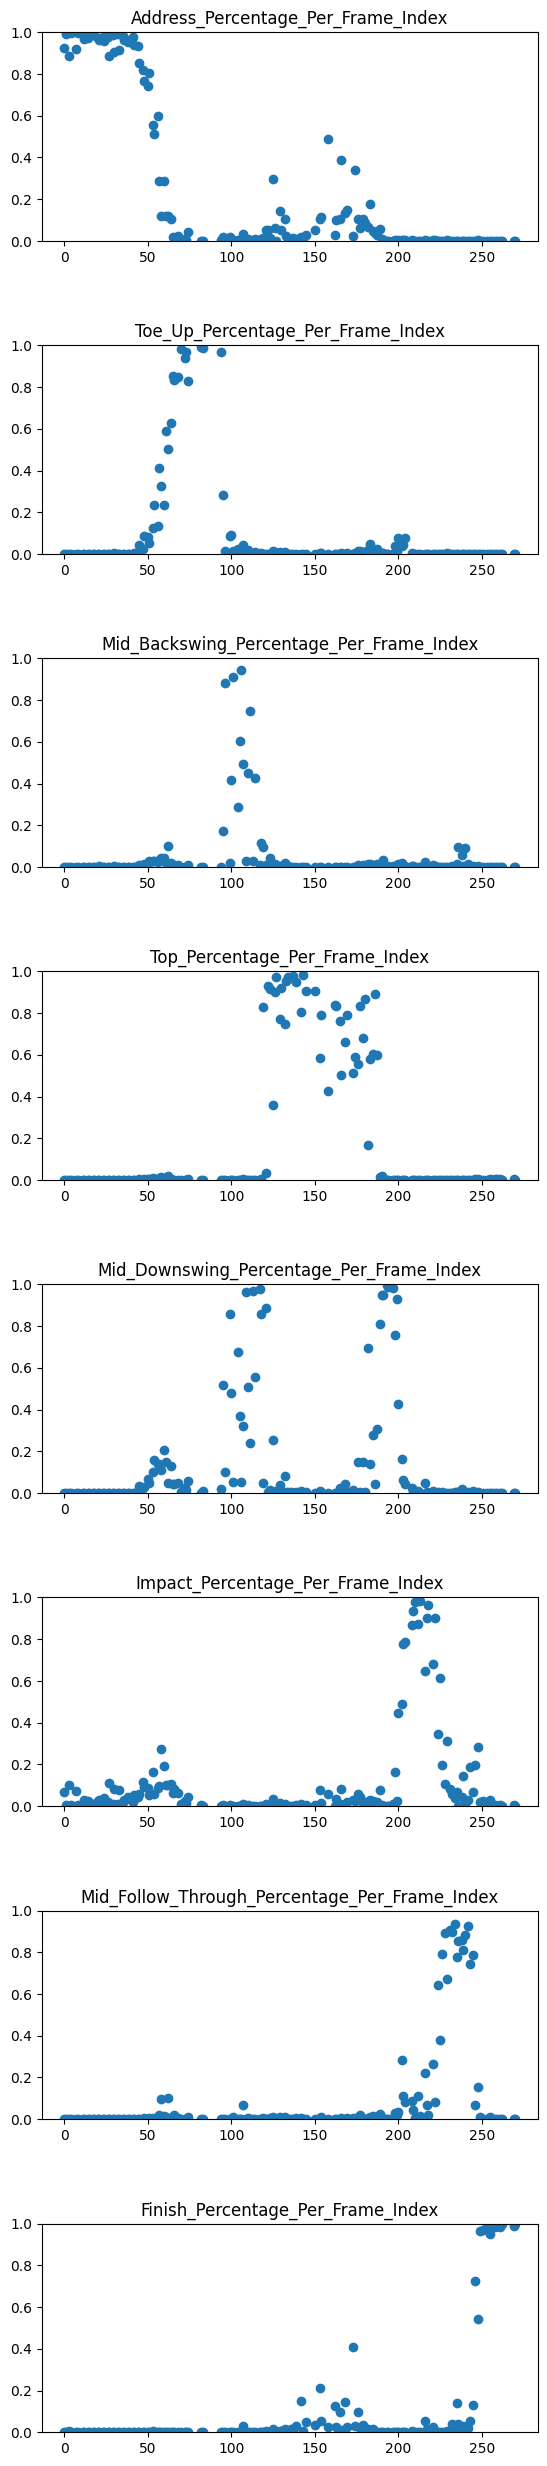

In [941]:
# Loop through the video to save all the frames into directories and get the 'lms_df' containing all the lm coordinates.
video_path = 'FT_All_Data/FT_Body_Data/FT_Body_Experimental/FO_Iron_2.mp4'
lms_df, lms_modified_df, lms_modified_2_df, events_percentages_df = analyze_video(video_path)
graph_events_percentages(events_percentages_df)

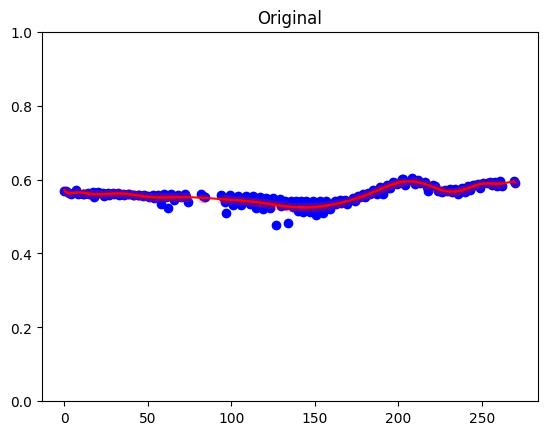

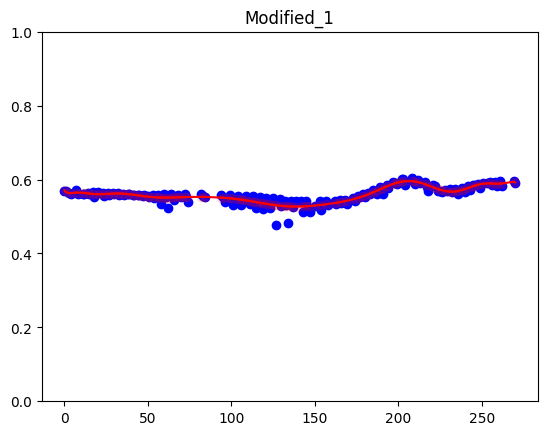

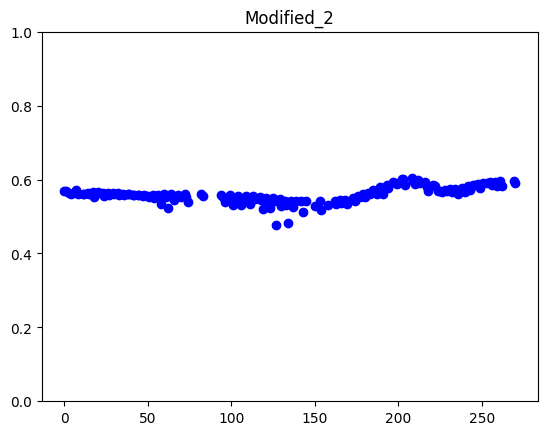

In [919]:
lm_to_look = 'Left_Knee_X_Position'
plt.scatter(lms_df.index.tolist(), lms_df[lm_to_look].tolist(), color='blue')
plt.scatter(lms_df.index.tolist(), lms_df[lm_to_look + '_Predicted'].tolist(), color='red', alpha=0.1)
for i in range(len(lms_df.index.tolist()) - 1):
    plt.plot([lms_df.index.tolist()[i], lms_df.index.tolist()[i+1]], [lms_df[lm_to_look + '_Predicted'].tolist()[i], lms_df[lm_to_look + '_Predicted'].tolist()[i+1]], color='red')
plt.ylim(0, 1)
plt.title('Original')
plt.show()
plt.scatter(lms_modified_df.index.tolist(), lms_modified_df[lm_to_look].tolist(), color='blue')
plt.scatter(lms_modified_df.index.tolist(), lms_modified_df[lm_to_look + '_Predicted_2'].tolist(), color='red', alpha=0.1)
for i in range(len(lms_modified_df.index.tolist()) - 1):
    plt.plot([lms_modified_df.index.tolist()[i], lms_modified_df.index.tolist()[i+1]], [lms_modified_df[lm_to_look + '_Predicted_2'].tolist()[i], lms_modified_df[lm_to_look + '_Predicted_2'].tolist()[i+1]], color='red')
plt.ylim(0, 1)
plt.title('Modified_1')
plt.show()
plt.scatter(lms_modified_2_df.index.tolist(), lms_modified_2_df[lm_to_look].tolist(), color='blue')
plt.ylim(0, 1)
plt.title('Modified_2')
plt.show()

In [943]:
# Find the 'max_event_percentage_frames', which is a list of the best frames for each event.
max_event_percentage_frames, first_occurrence_frames, last_occurrence_frames = find_max_event_percentage_frames(events_percentages_df)
for max_event_percentage_frame in max_event_percentage_frames:
    show_video_frame(video_path, max_event_percentage_frame)

In [944]:
print(max_event_percentage_frames)

[4, 82, 106, 143, 193, 213, 234, 270]


In [942]:
events_percentages_df

Address        Toe_Up  Mid_Backswing       Top  Mid_Downswing  \
Frame_Index                                                                   
0            0.925060  5.224696e-04   1.270302e-03  0.001942   1.532844e-03   
1            0.991256  1.124993e-04   2.319388e-04  0.000512   8.523270e-04   
3            0.888606  5.483427e-04   1.711209e-03  0.001948   2.312431e-03   
4            0.995949  9.395323e-05   1.505199e-04  0.000202   8.680325e-05   
7            0.920295  6.346921e-04   1.130496e-03  0.001345   1.316497e-03   
8            0.994735  2.429288e-05   9.138646e-05  0.000133   1.151194e-04   
11           0.991047  4.536377e-05   1.148092e-04  0.000233   1.338618e-04   
12           0.968169  1.561575e-04   5.837860e-04  0.000360   8.262348e-04   
14           0.974317  1.439338e-04   4.014063e-04  0.000404   2.367777e-04   
15           0.979839  8.650656e-04   2.223233e-03  0.000838   1.338708e-03   
17           0.988935  2.549615e-04   3.972528e-04  0.000425   2.742620e-04   
18           0.987976  6.122715e-04   7.095278e-04  0.000511   2.630280e-04   
20           0.971906  2.404533e-04   6.182367e-04  0.000486   5.175954e-04   
21           0.964330  1.505448e-03   2.811872e-03  0.000571   5.339361e-04   
23           0.975686  4.677378e-04   7.928814e-04  0.000390   8.681691e-04   
24           0.956927  1.995292e-03   2.201122e-03  0.001187   3.952757e-04   
26           0.978620  2.383642e-04   5.240616e-04  0.000355   5.333708e-04   
27           0.886011  1.525062e-03   6.486719e-04  0.000506   1.905060e-04   
29           0.988182  3.817803e-04   6.468659e-04  0.000304   5.185160e-04   
30           0.904040  6.243815e-03   4.636665e-03  0.001646   1.284728e-03   
32           0.989581  1.860642e-04   3.731682e-04  0.000281   5.398957e-04   
33           0.916959  6.719871e-04   1.118933e-03  0.000519   3.249096e-04   
35           0.979890  1.668720e-04   3.110754e-04  0.000169   2.895104e-04   
36           0.964183  1.217858e-03   8.655562e-04  0.001563   7.458445e-04   
38           0.951141  6.723100e-04   7.445336e-04  0.000715   5.425277e-04   
39           0.961079  1.014012e-03   6.767671e-04  0.001164   1.302938e-03   
41           0.975652  4.410415e-04   4.250353e-04  0.000642   7.355494e-04   
42           0.940124  2.842834e-03   1.273168e-03  0.001346   1.601601e-03   
44           0.931896  1.158588e-02   2.961815e-03  0.001513   6.239155e-03   
45           0.851789  4.508743e-02   7.525183e-03  0.003886   3.289438e-02   
47           0.817002  2.307222e-02   1.194325e-02  0.002791   2.494511e-02   
48           0.766332  8.727923e-02   1.289253e-02  0.006954   2.864930e-02   
50           0.742498  8.206589e-02   1.370890e-02  0.003953   6.680400e-02   
51           0.802570  5.236495e-02   2.678423e-02  0.006085   5.045087e-02   
53           0.556657  1.262472e-01   3.068572e-02  0.008028   1.019188e-01   
54           0.513584  2.343852e-01   2.818624e-02  0.006006   1.573333e-01   
56           0.600421  1.329219e-01   2.562584e-02  0.006850   1.416640e-01   
57           0.286620  4.142447e-01   3.369832e-02  0.007942   1.402594e-01   
58           0.121921  3.277499e-01   4.376956e-02  0.017105   1.132440e-01   
60           0.288396  2.363443e-01   4.404498e-02  0.010089   2.057291e-01   
61           0.118933  5.896643e-01   2.159599e-02  0.007134   1.503822e-01   
62           0.120278  5.035959e-01   9.875627e-02  0.021960   4.898560e-02   
64           0.107314  6.297542e-01   1.783950e-02  0.004117   1.308405e-01   
65           0.017383  8.546874e-01   9.497006e-03  0.002869   4.498106e-02   
66           0.011879  8.347219e-01   8.555931e-03  0.001404   4.212069e-02   
68           0.024024  8.479298e-01   9.661593e-03  0.002740   4.964568e-02   
70           0.001364  9.829832e-01   7.214073e-04  0.000279   5.696047e-03   
72           0.008019  9.405053e-01   2.183638e-03  0.000755   2.467849e-02   
73           0.003445  9.659249e-01   1.357706e-03  0.000698   1

In [947]:
show_video_frame(video_path, 218)

In [893]:
max_event_percentage_frames

[18, 66, 81, 93, 116, 125, 131, 145]

In [99]:
# Alternative method for finding the max_event_percentage_frames.
# max_event_percentage_frames_2 = []
# previous_frame = 0
# event_int = 4
# for event in EVENT_STRS.values():
    # event_percentages = events_percentages_df[event]
    # frame_numbers = events_percentages_df.index
    # filtered_percentages = event_percentages[(event_percentages.index > previous_frame) & (event_percentages.index < (len(events_percentages_df) * (event_int / len(EVENT_STRS))))].tolist()
    # filtered_frame_numbers = frame_numbers[(event_percentages.index > previous_frame) & (event_percentages.index < (len(events_percentages_df) * (event_int / len(EVENT_STRS))))].tolist()
    # if len(filtered_percentages) == 0:
        # max_event_percentage_frames.append(0)
        # continue
    # middle_occurrence_frame = filtered_frame_numbers[find_middle_occurrence(filtered_percentages)]
    # max_event_percentage_frames_2.append(middle_occurrence_frame)
    # previous_frame = middle_occurrence_frame
    # event_int += 1
# print(max_event_percentage_frames_2)

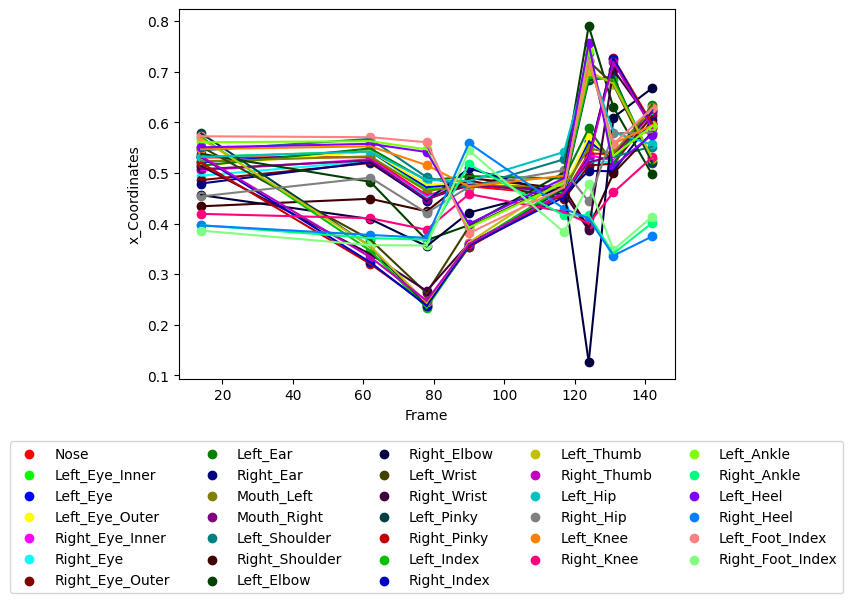

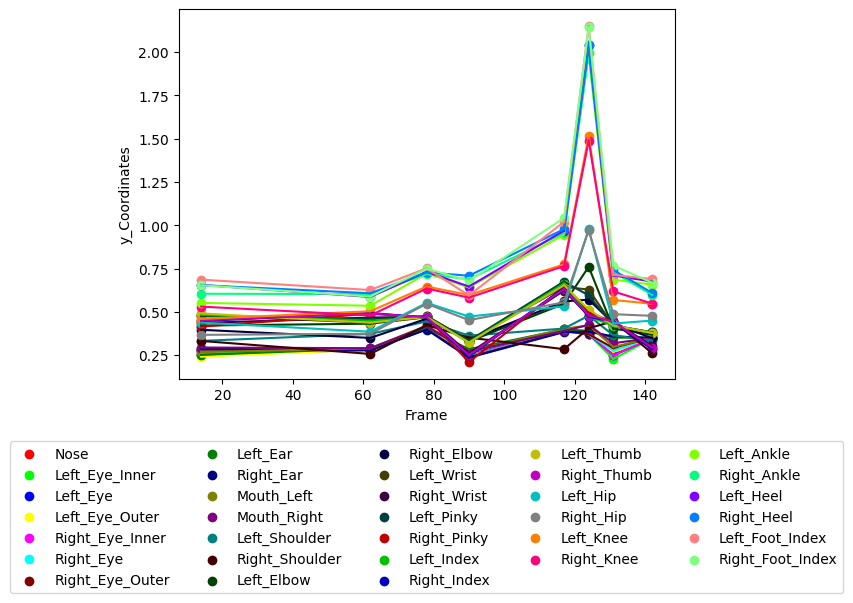

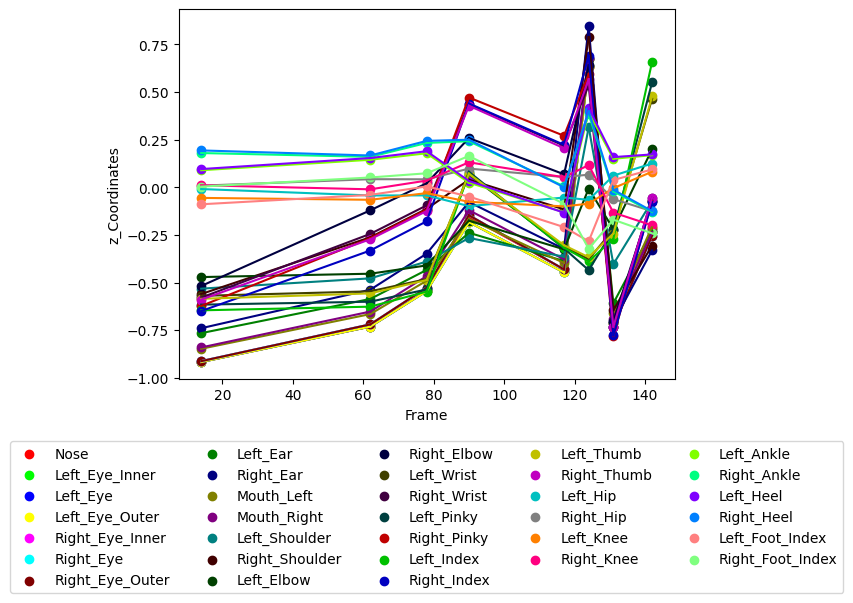

In [149]:
DISTINCT_COLORS_MODIFIED = [tuple((value / 255) for value in tuple_data) for tuple_data in DISTINCT_COLORS]
indep = events_lms_df.index.tolist()
for char in XYZ:
    for lm_int in mp_pose.PoseLandmark:
        distinct_color = DISTINCT_COLORS_MODIFIED[lm_int]
        lm_str = lm_int_to_lm_str(lm_int)
        column_label = lm_str + '_' + char.capitalize() + '_Position'
        dep = events_lms_df[column_label].tolist()
        plt.scatter(indep, dep, color=distinct_color, label=lm_str)
        for i in range(len(indep) - 1):
            plt.plot([indep[i], indep[i+1]], [dep[i], dep[i+1]], color=distinct_color)
    plt.xlabel('Frame')
    plt.ylabel(char + '_Coordinates')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


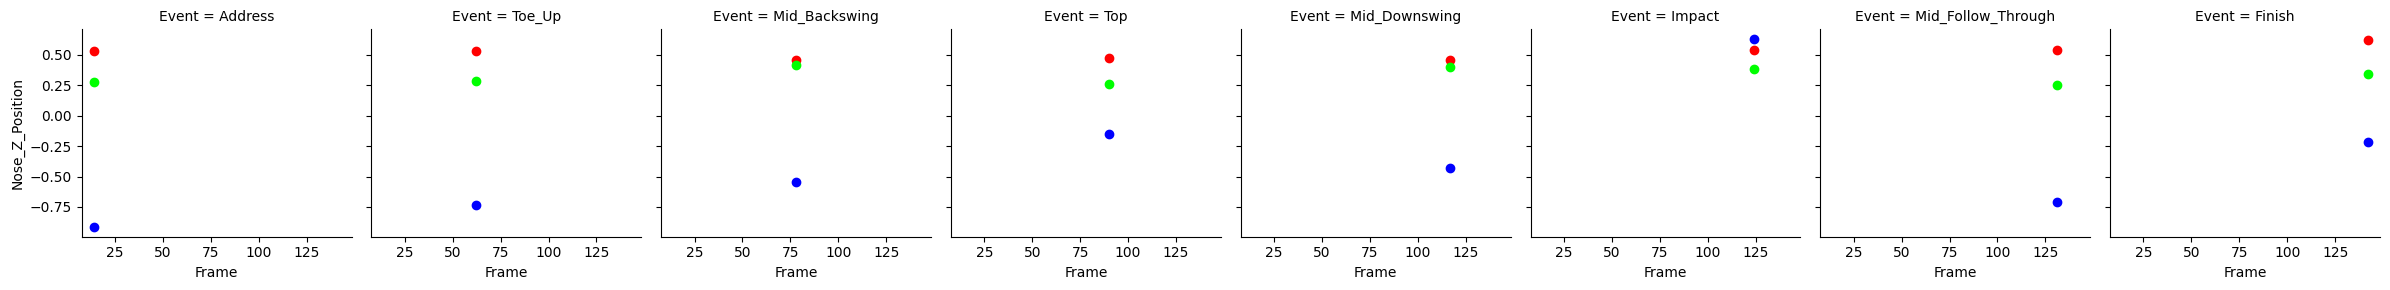

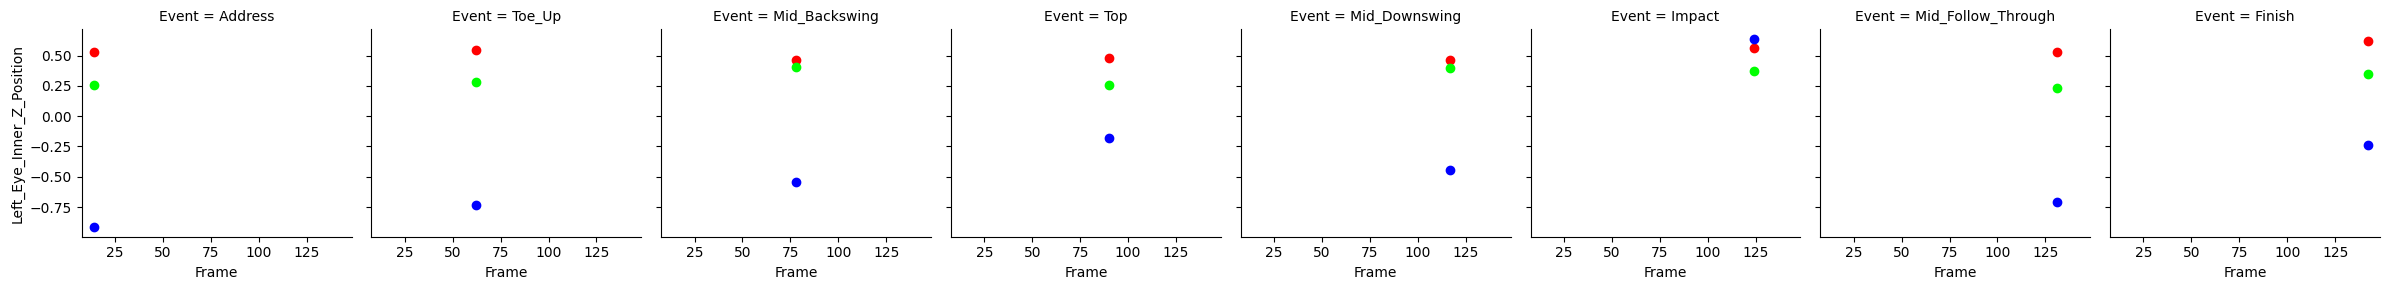

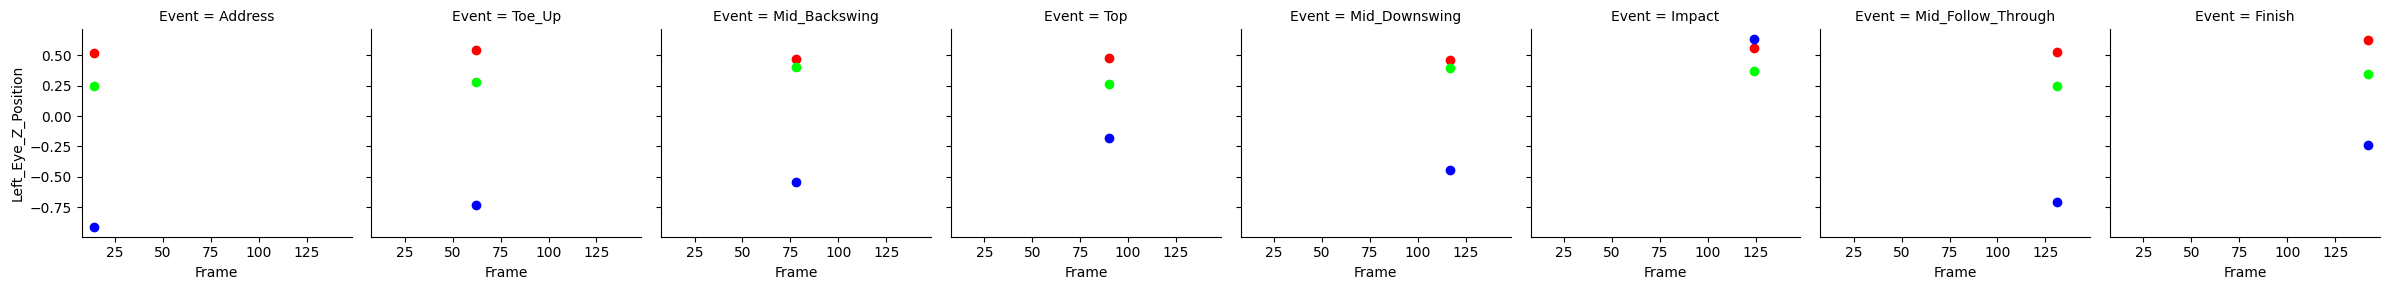

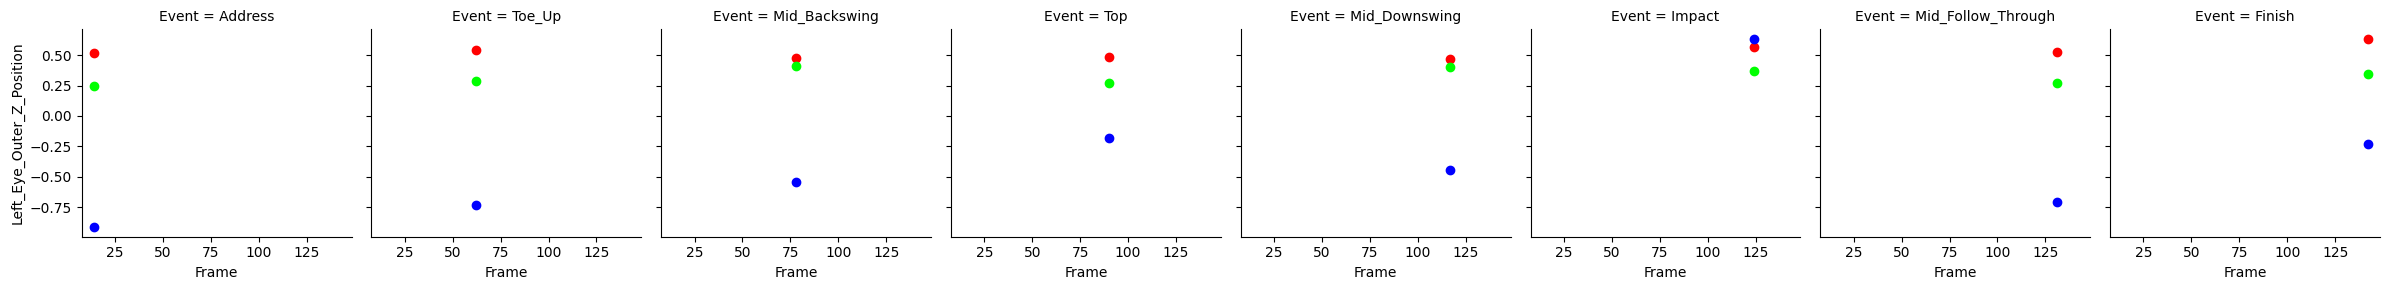

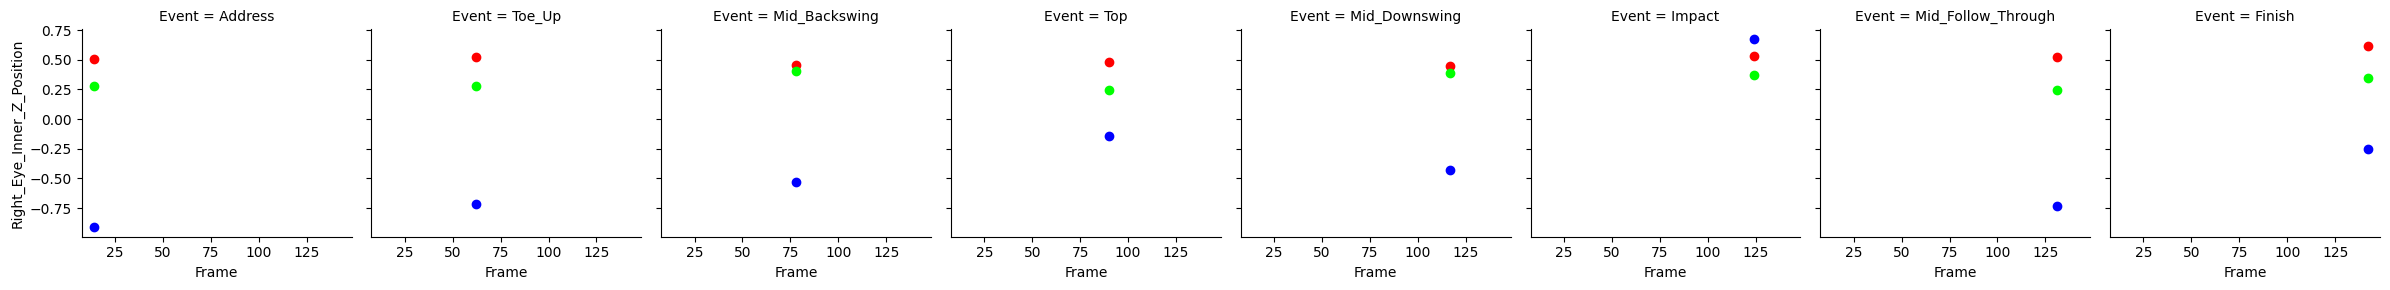

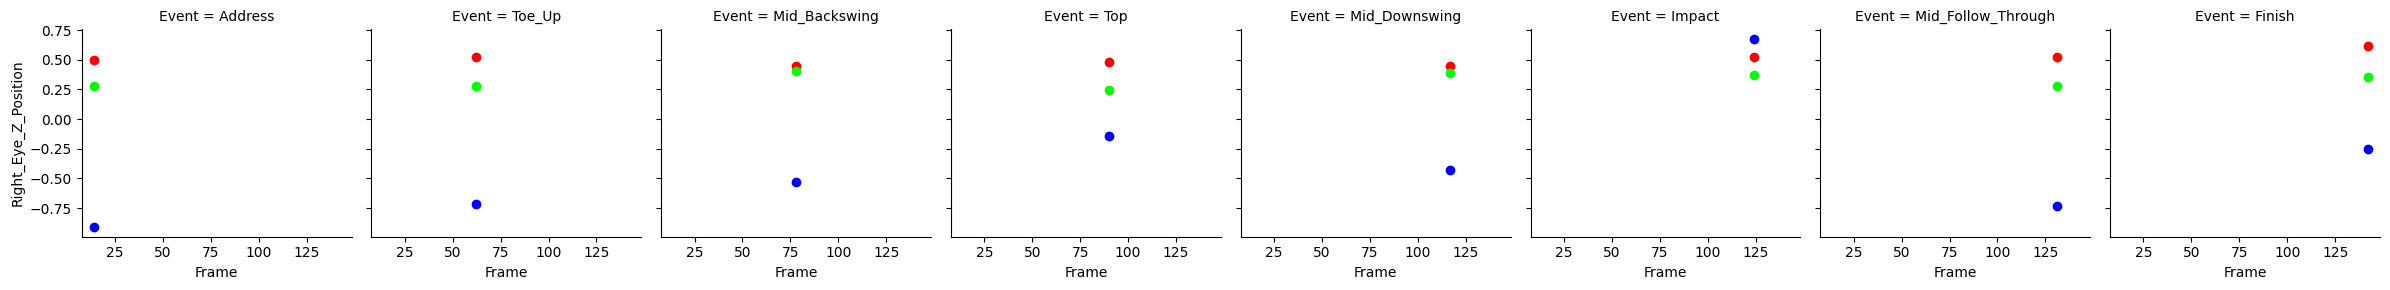

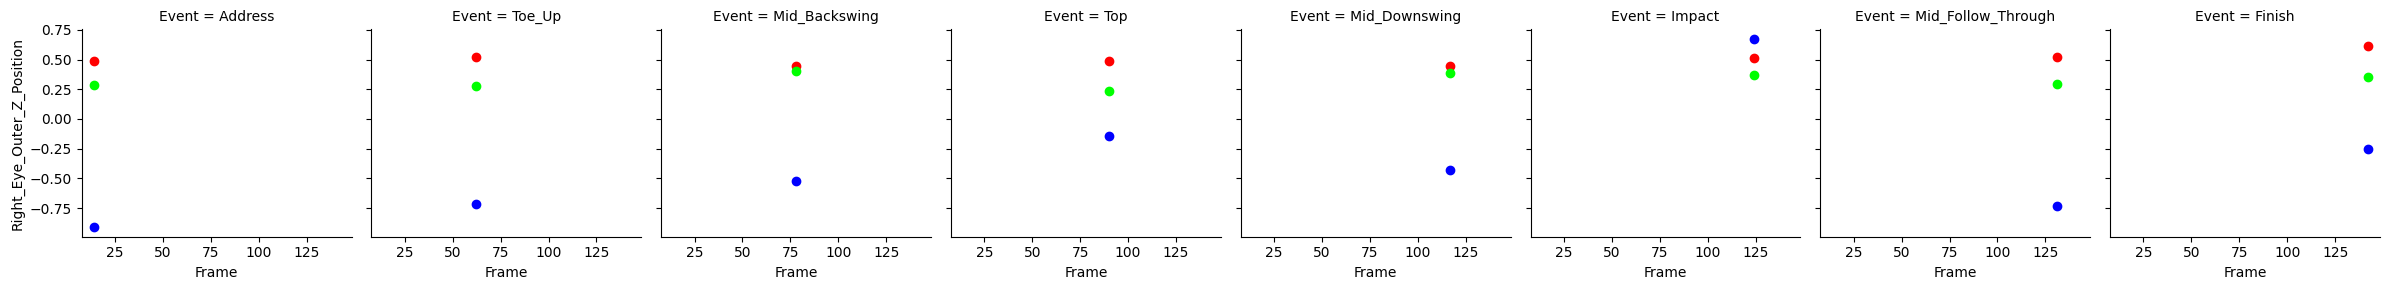

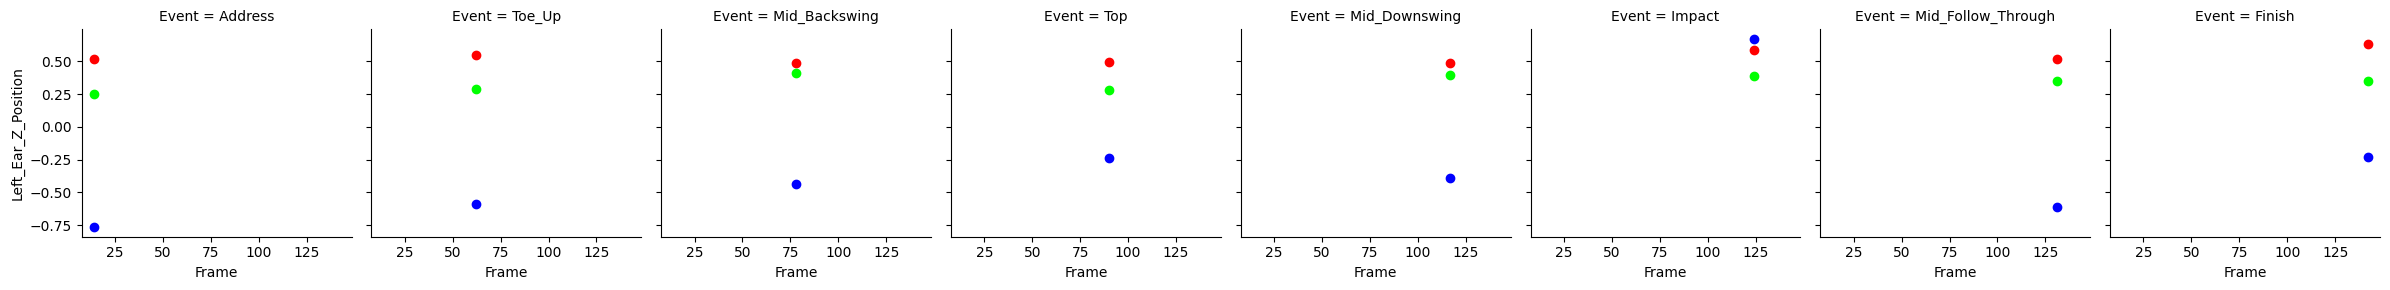

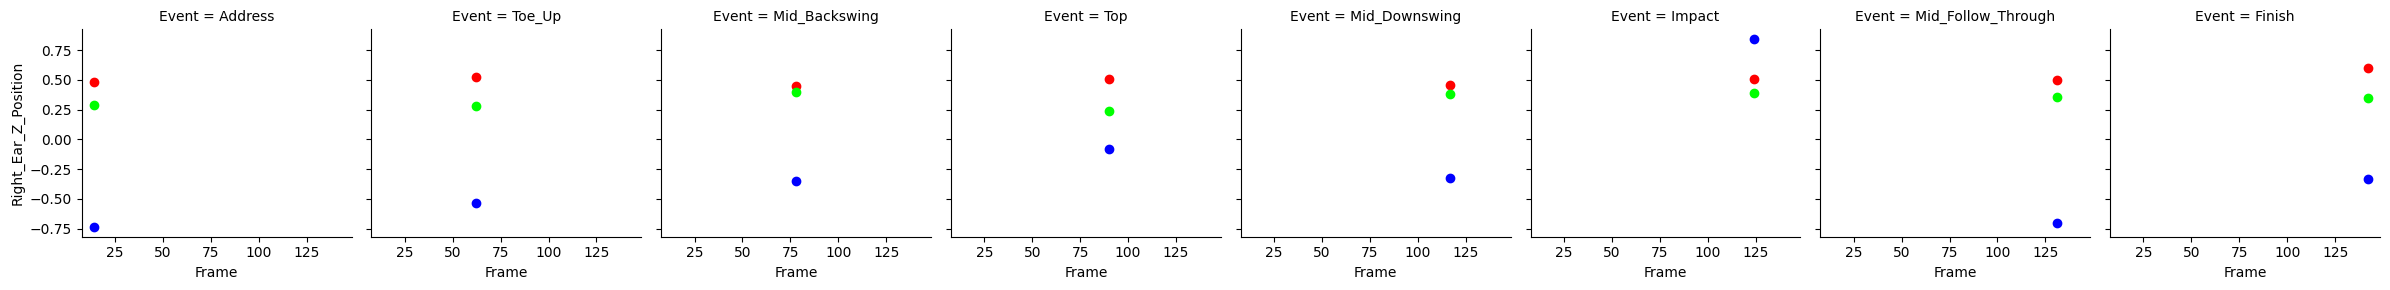

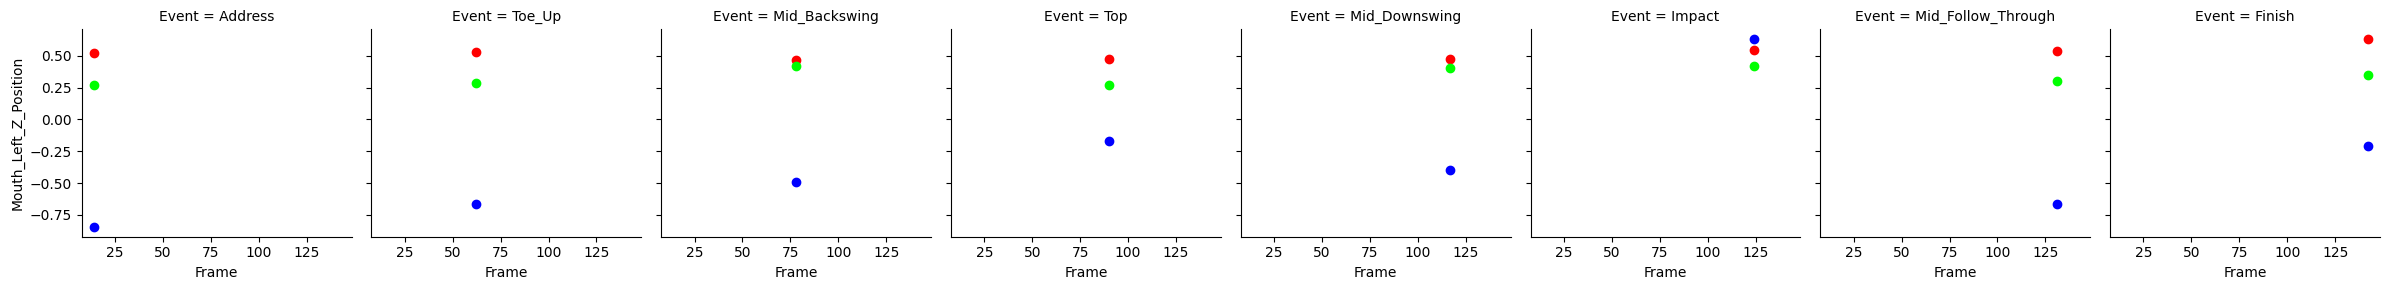

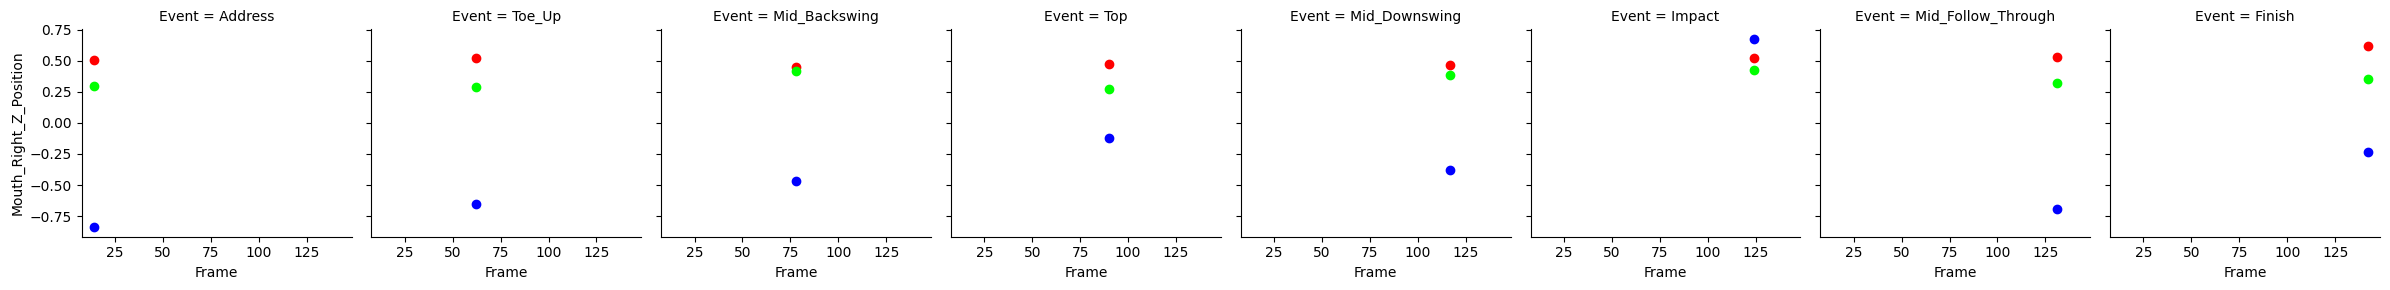

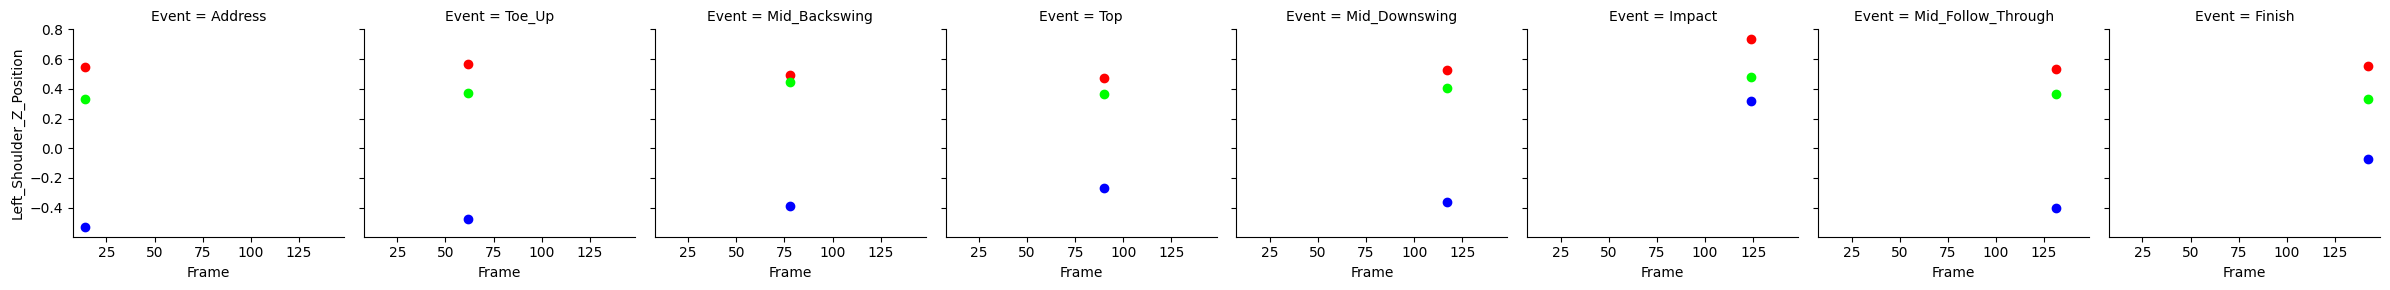

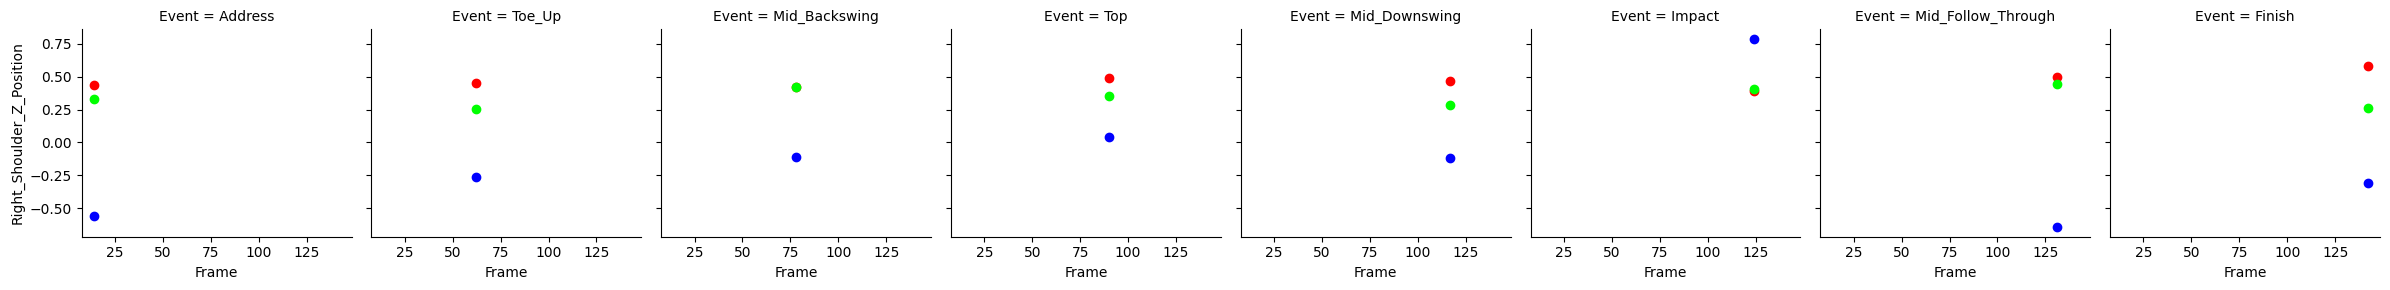

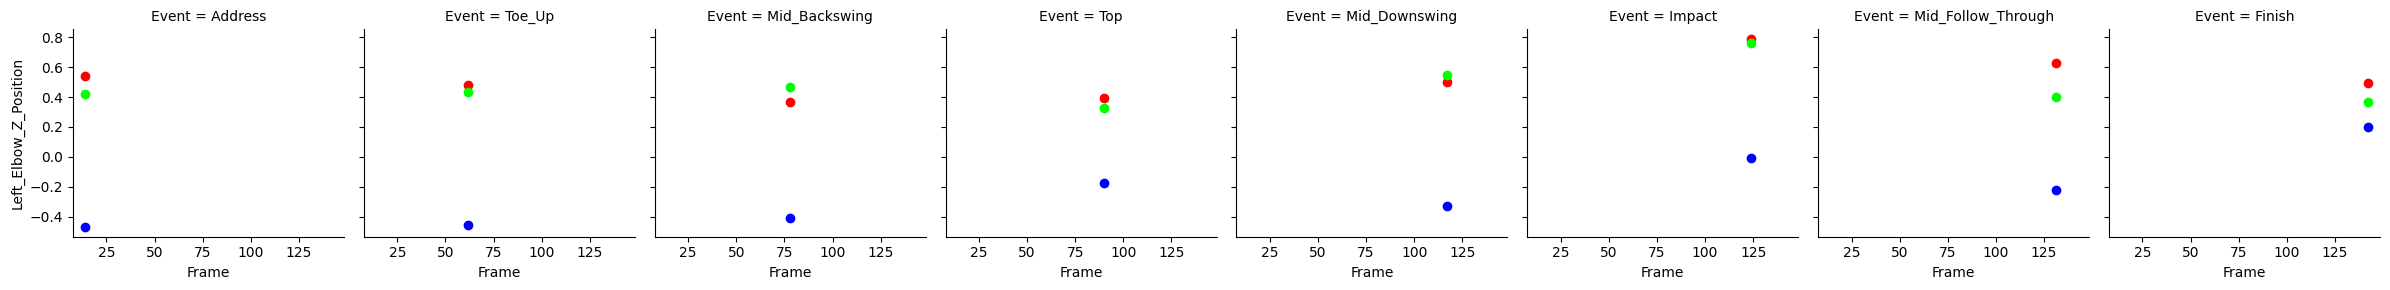

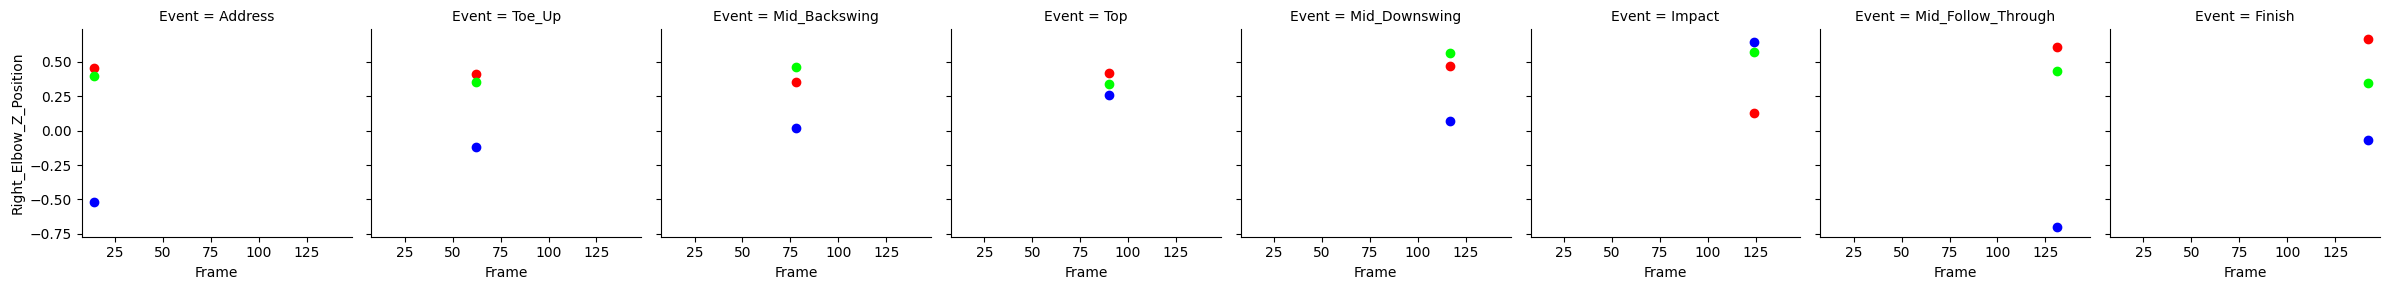

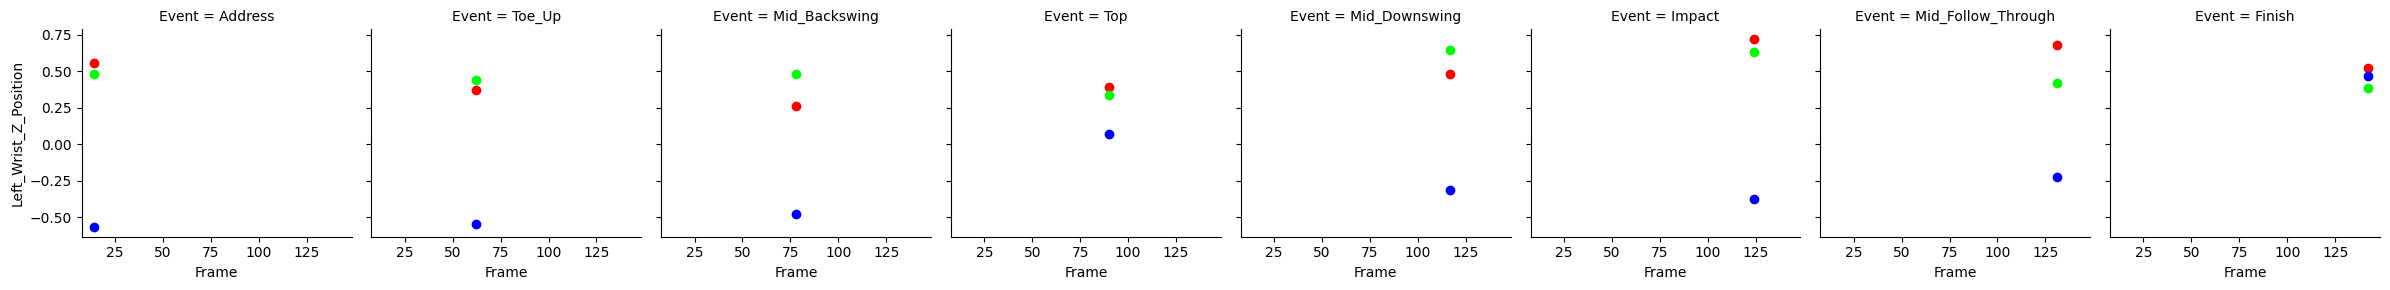

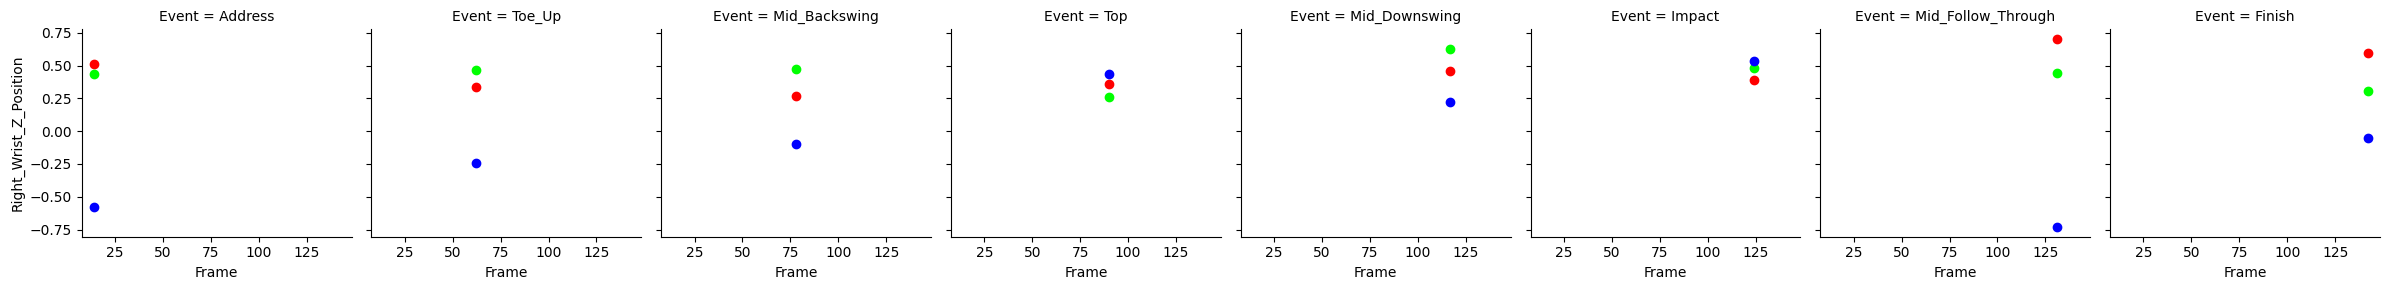

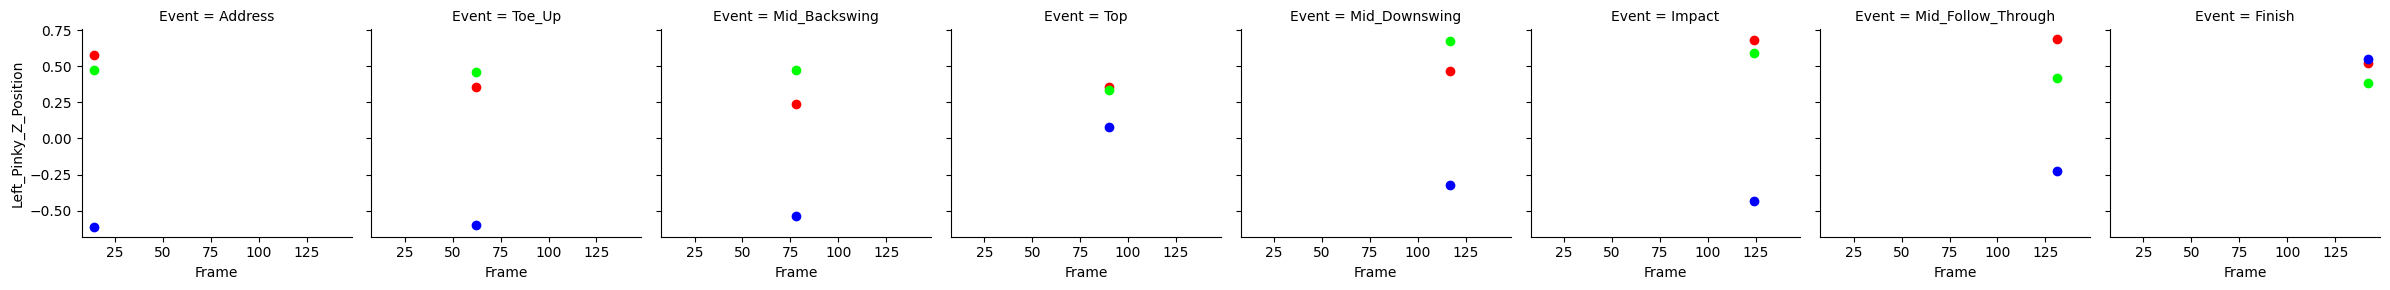

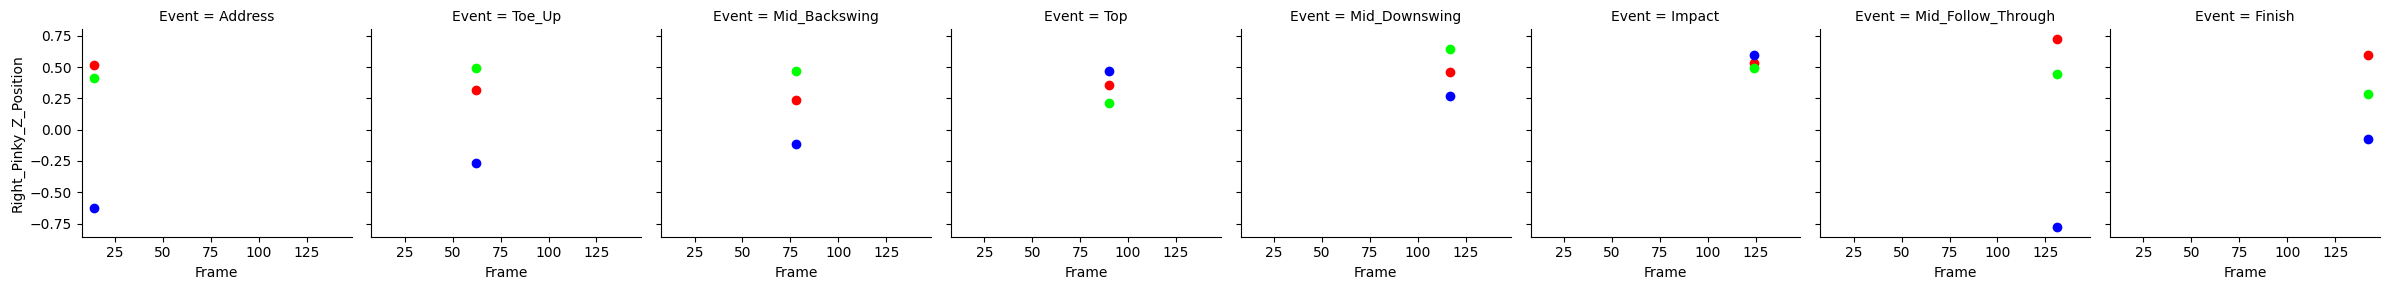

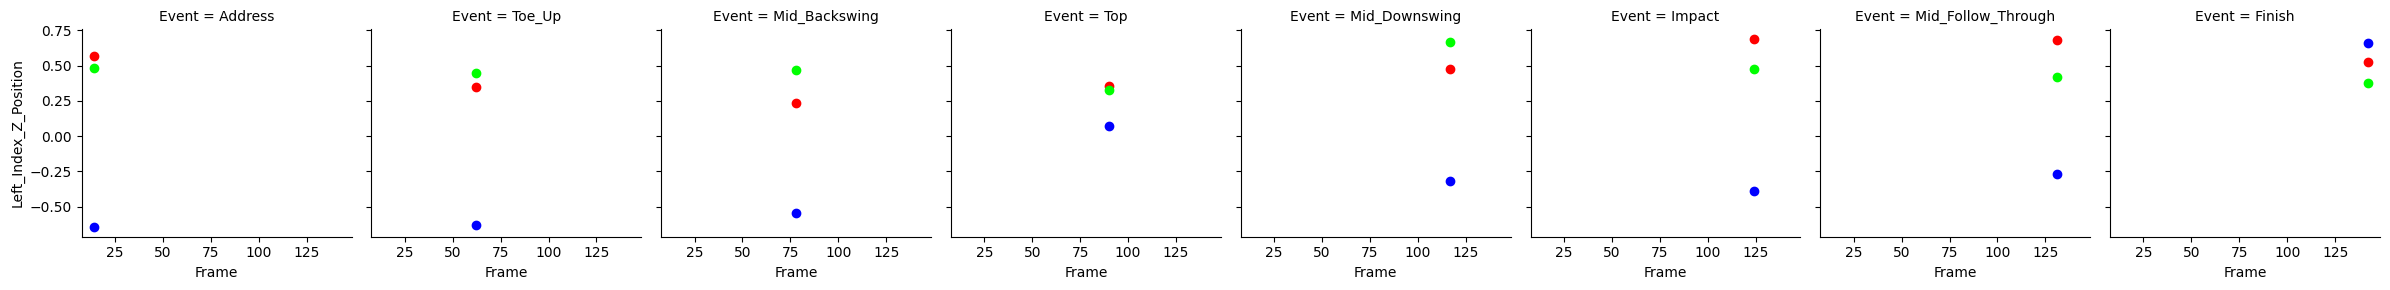

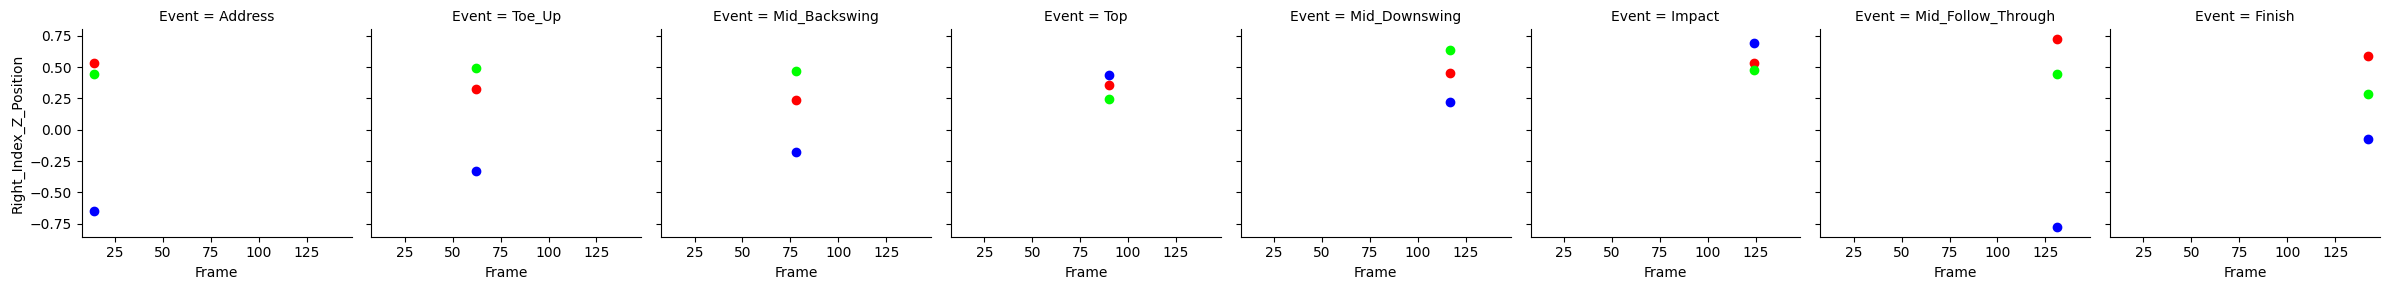

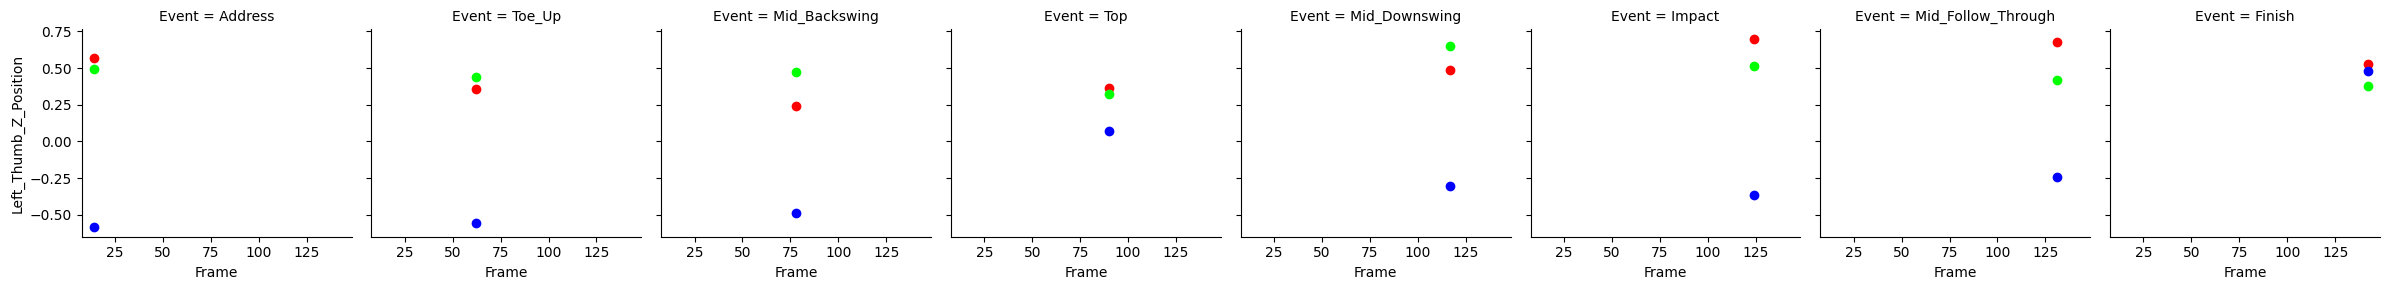

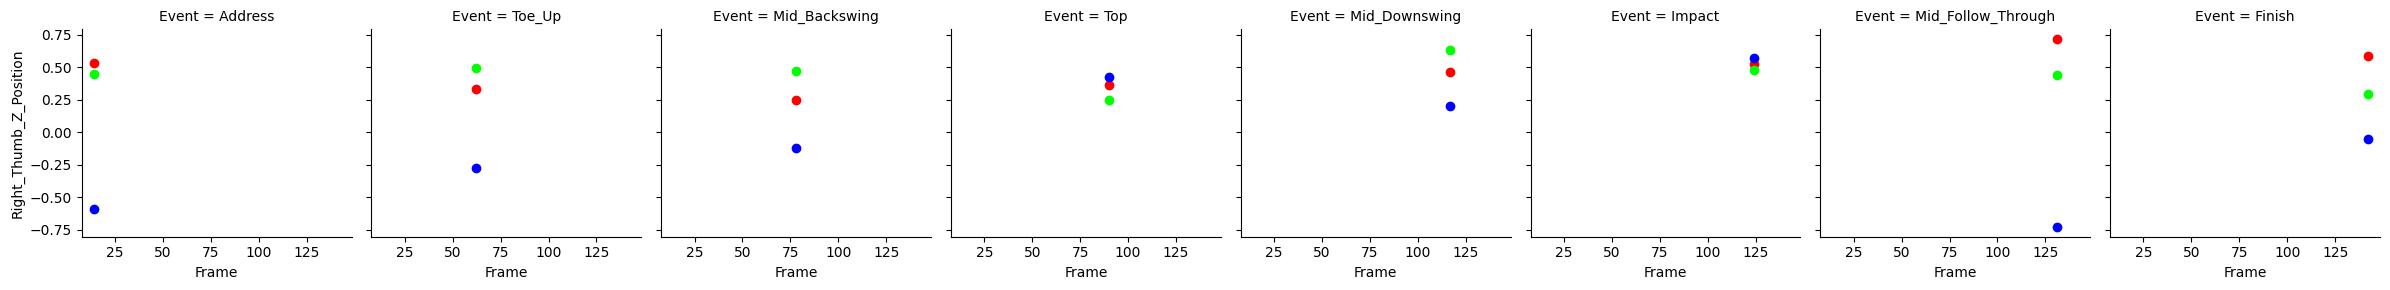

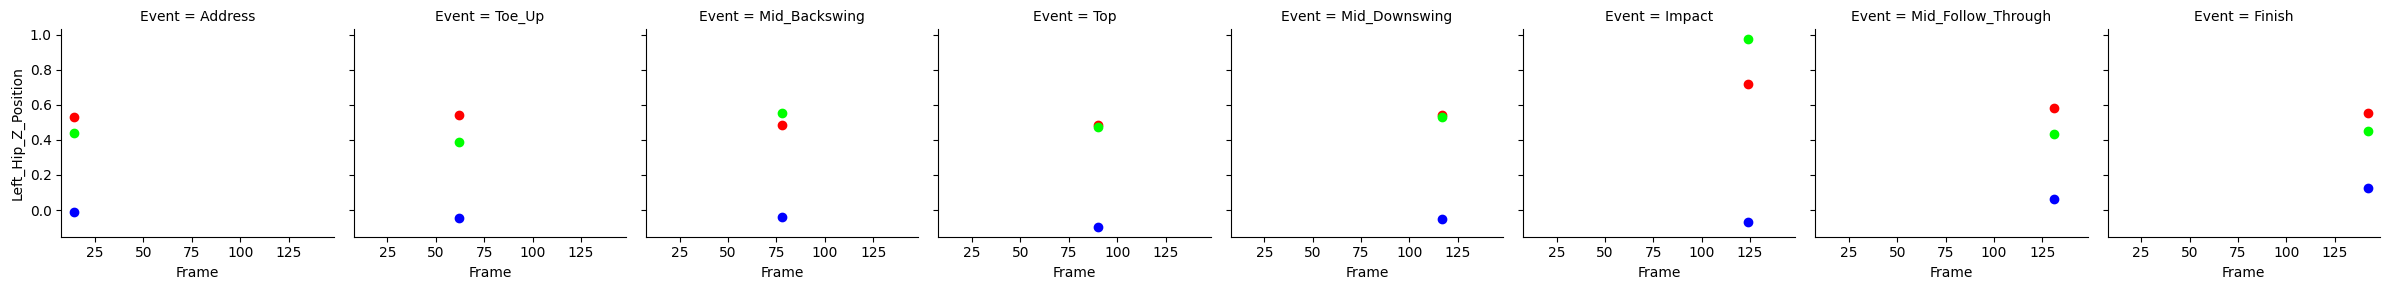

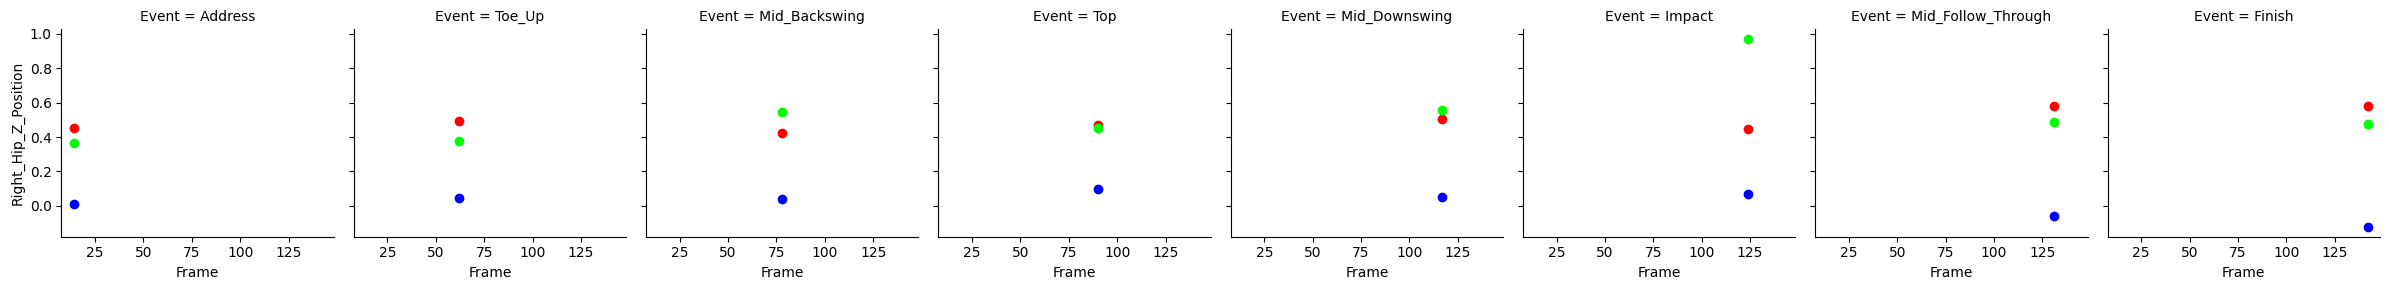

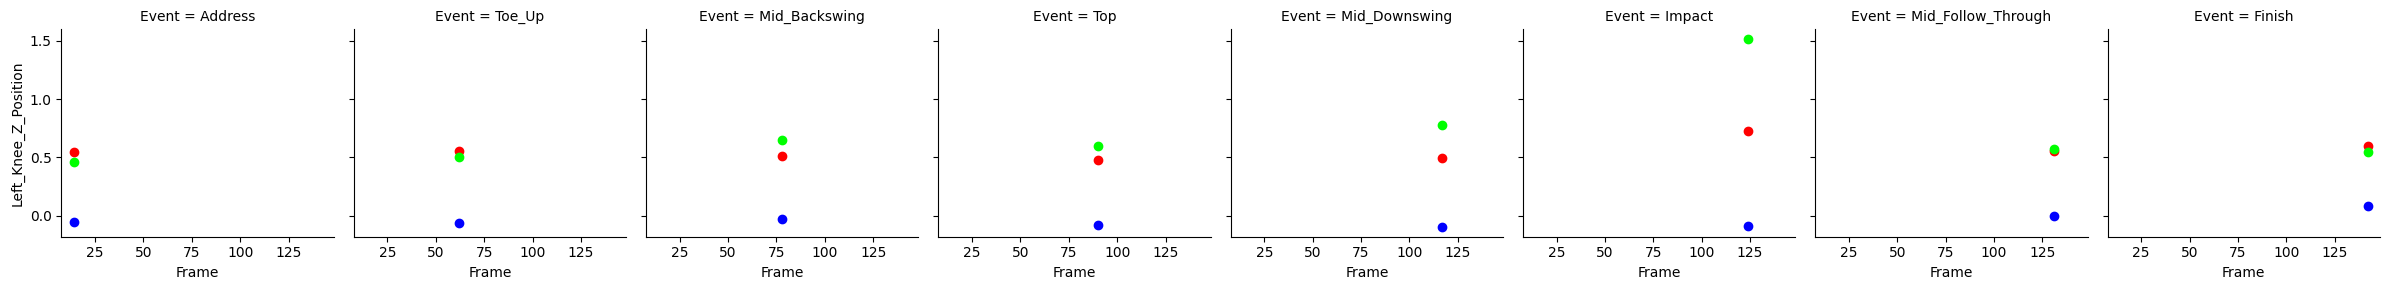

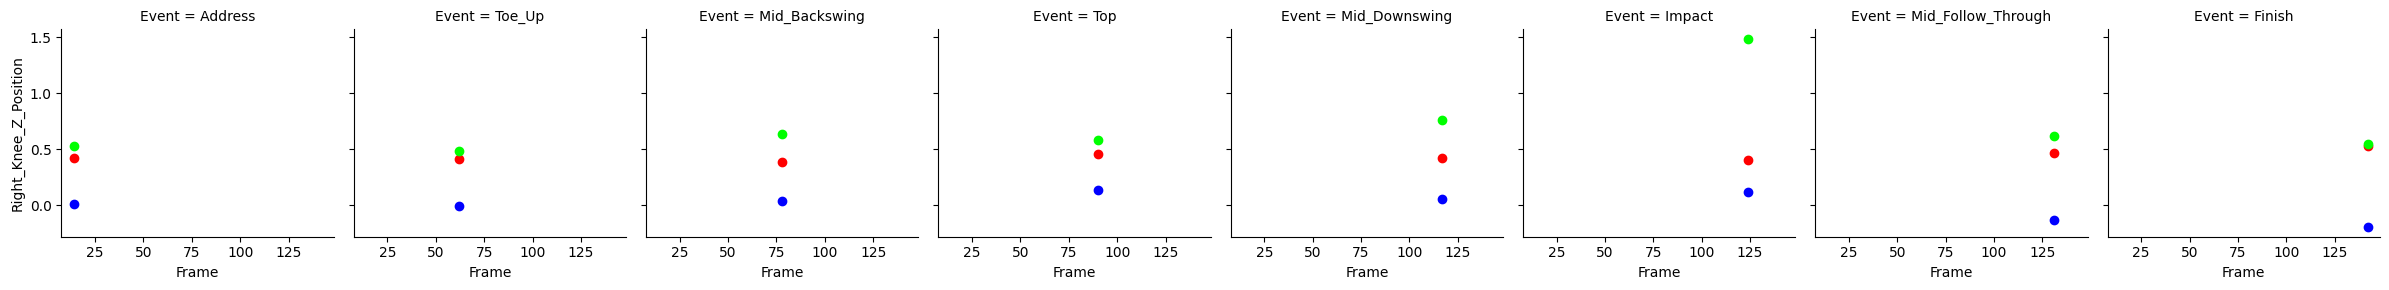

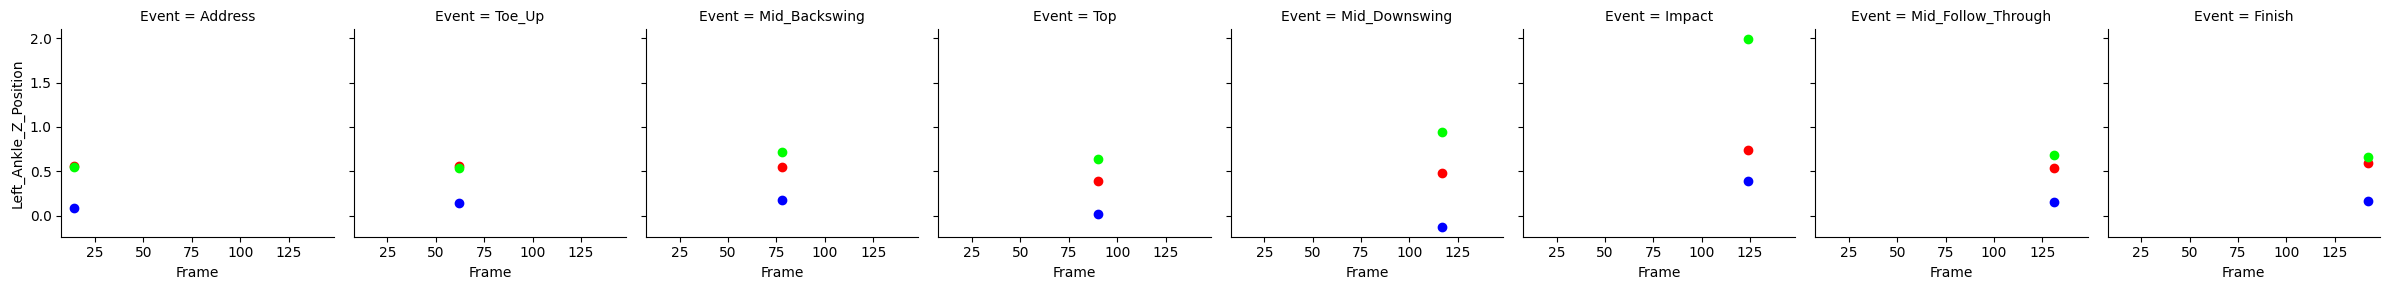

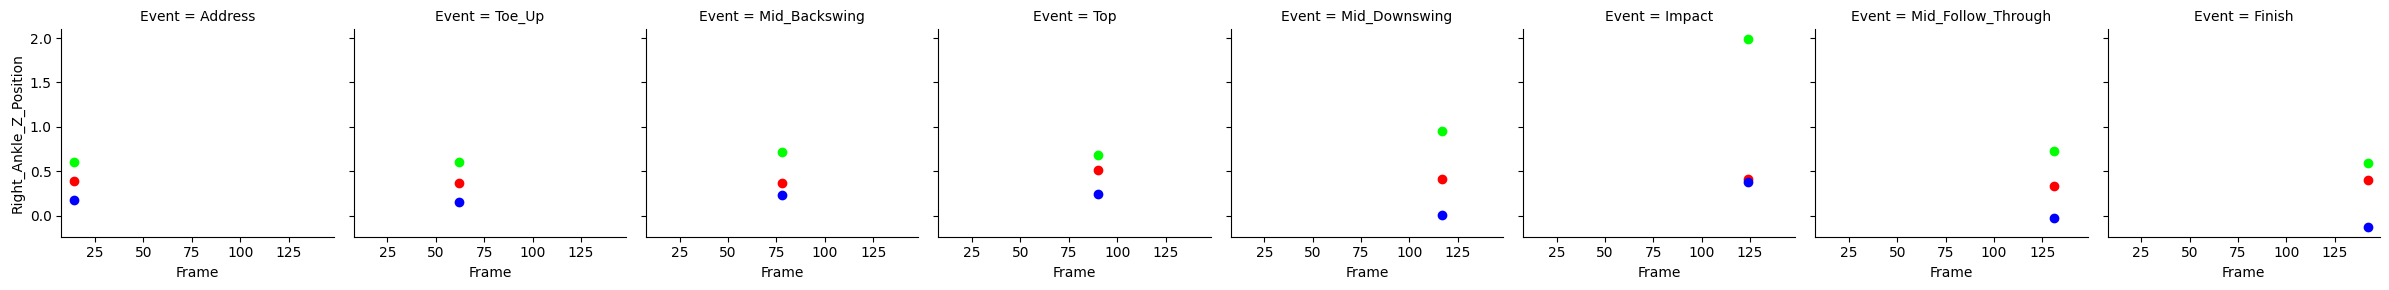

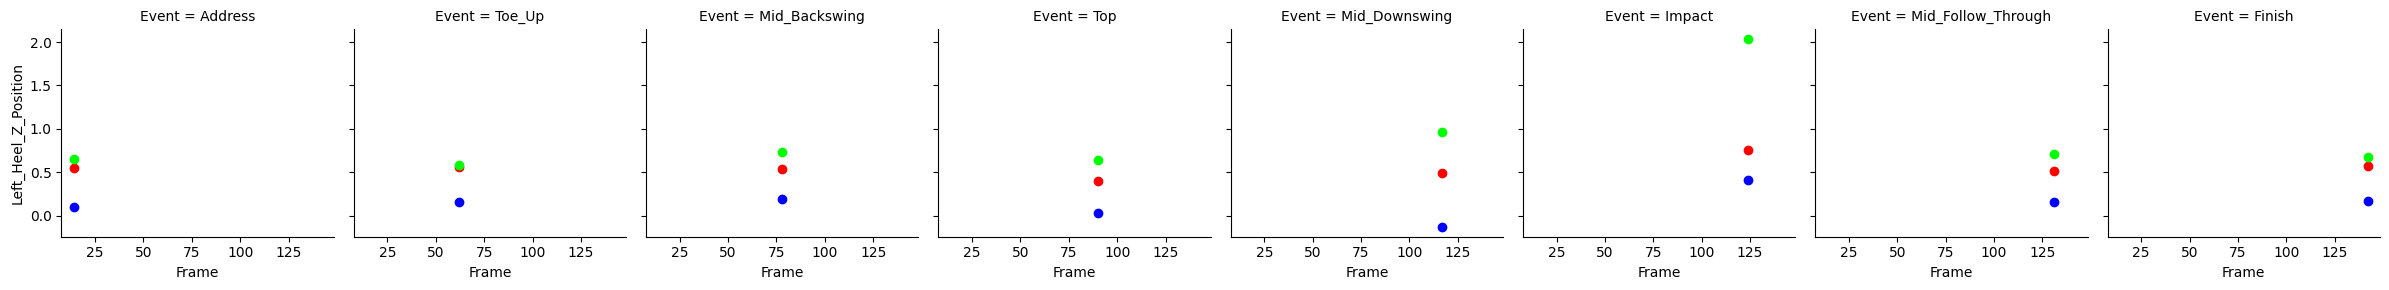

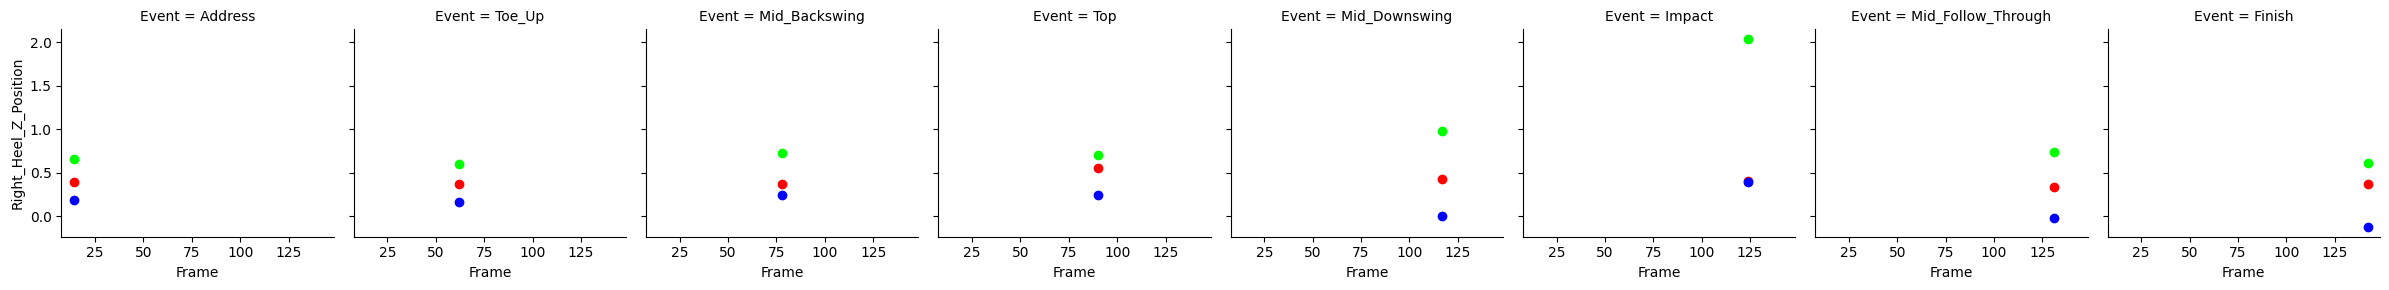

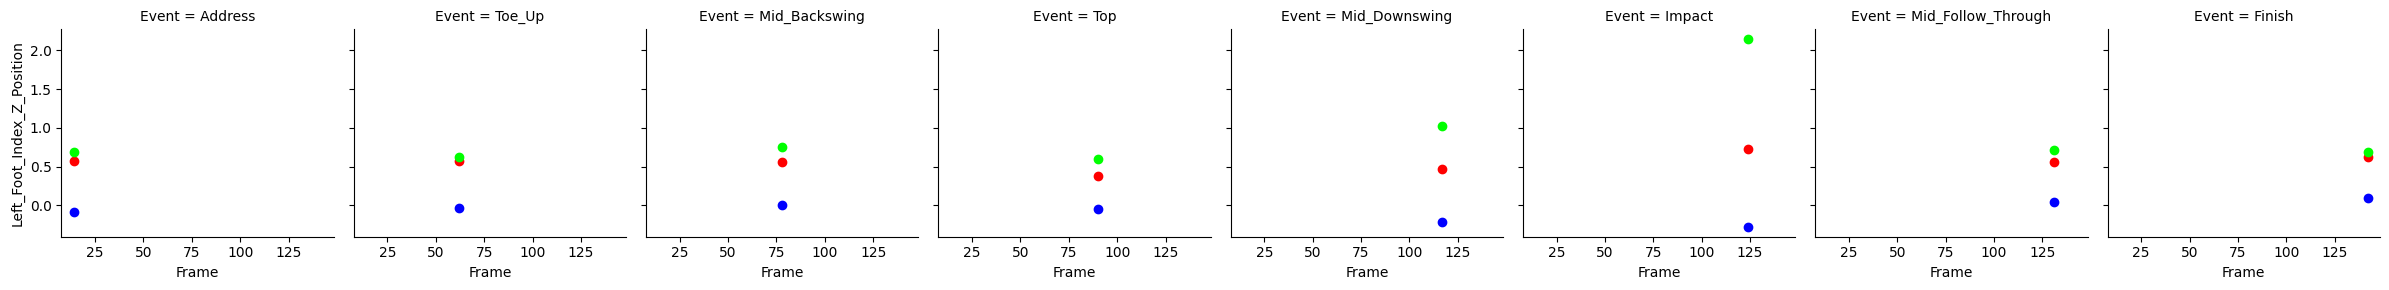

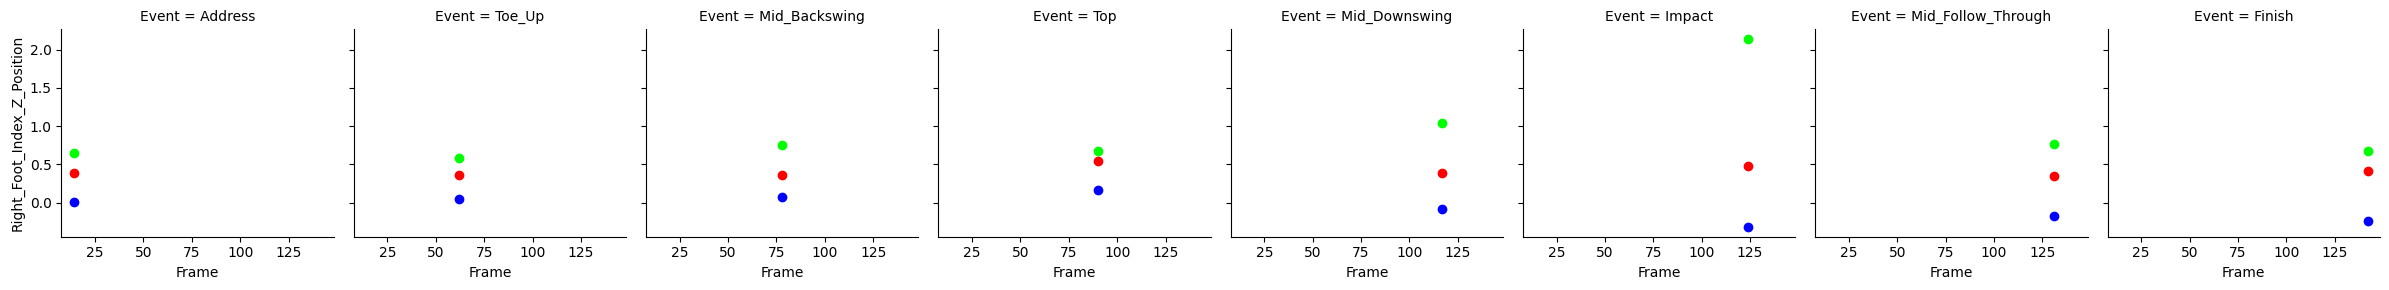

In [166]:
for lm_int in mp_pose.PoseLandmark:
    counter = 0
    lm_str = lm_int_to_lm_str(lm_int)
    g = sns.FacetGrid(events_lms_df, col='Event')
    for char in XYZ:
        column_label = column_label = lm_str + '_' + char.capitalize() + '_Position'
        g.map(plt.scatter, 'Frame', column_label, color=DISTINCT_COLORS_MODIFIED[counter], label=column_label)
        counter += 1
    g.set_titles(col_template='{col_name}')
    g.set_titles(row_template='{row_name}\b\b\b\b\b\b\b\b\b')

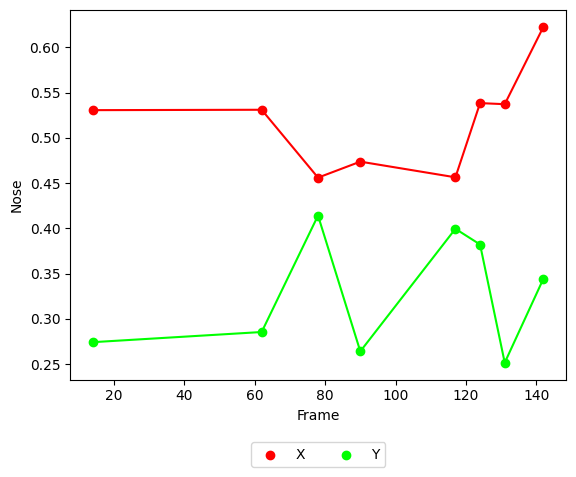

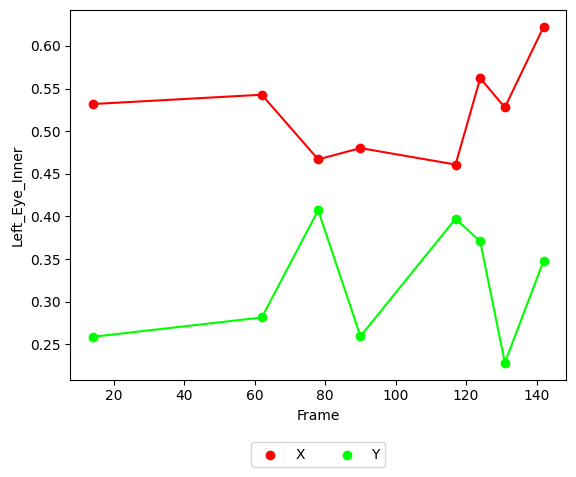

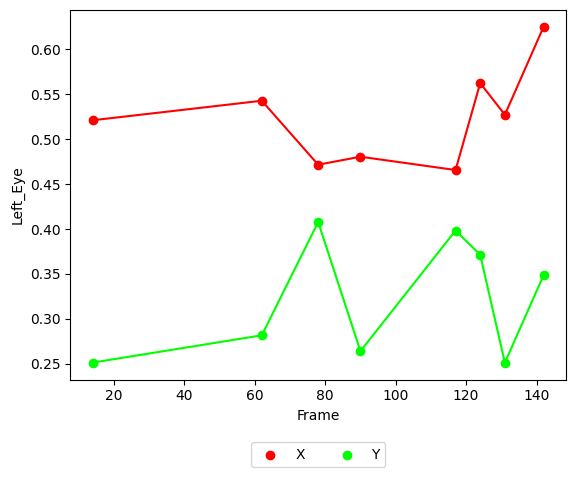

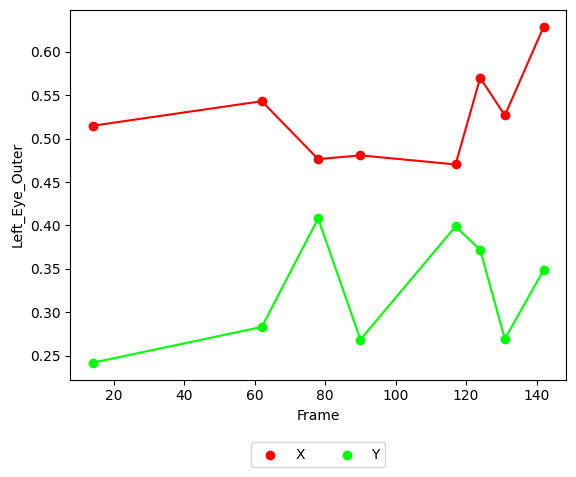

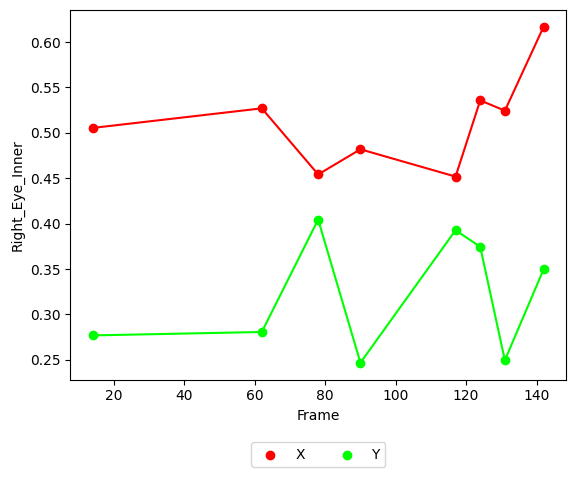

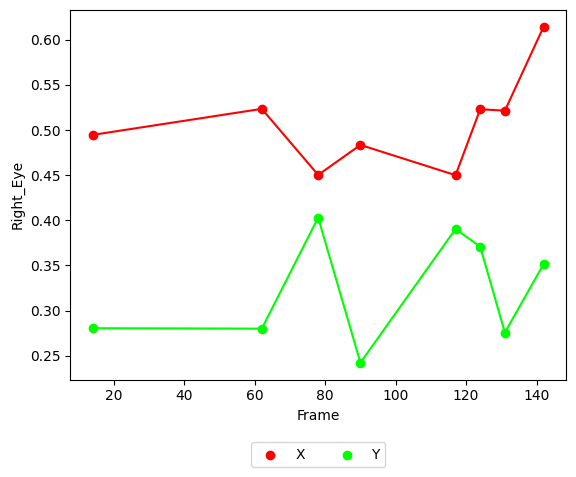

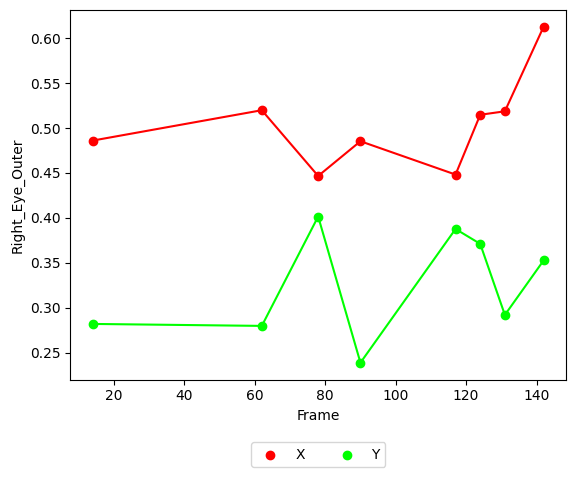

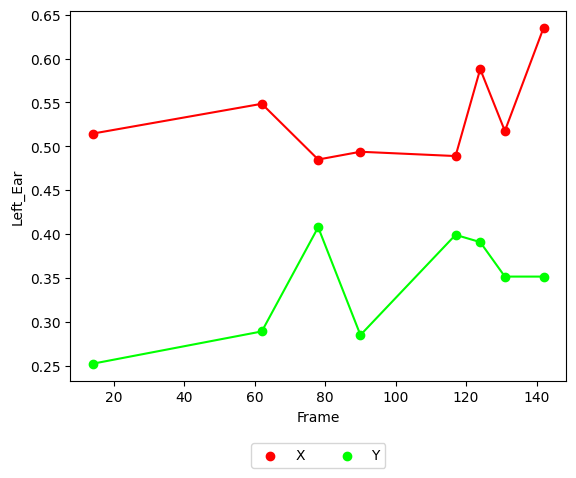

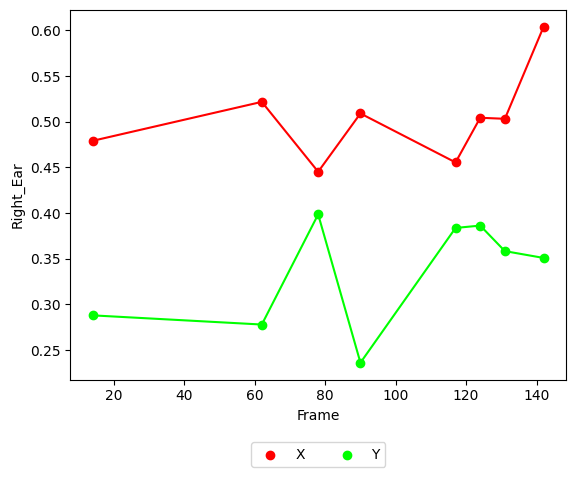

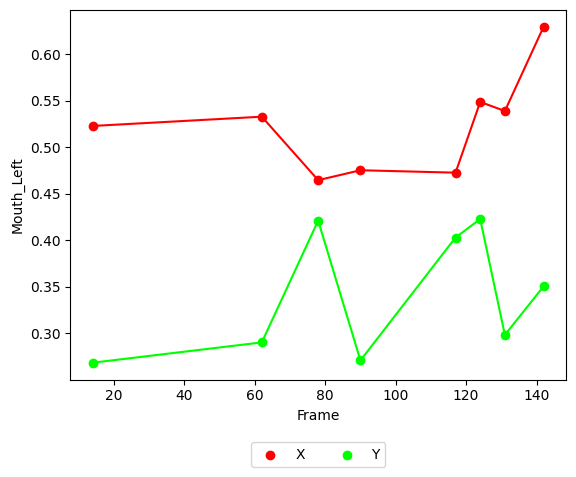

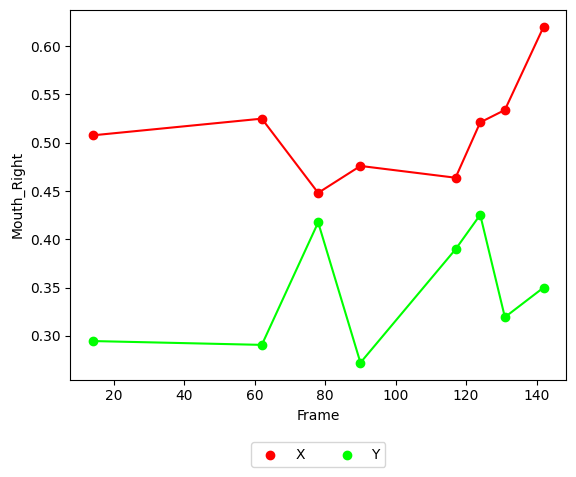

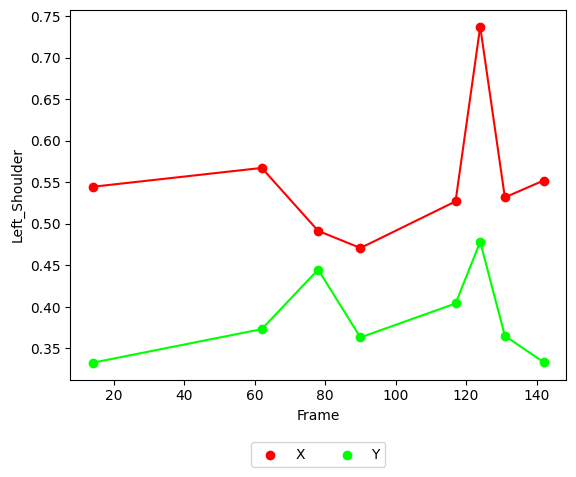

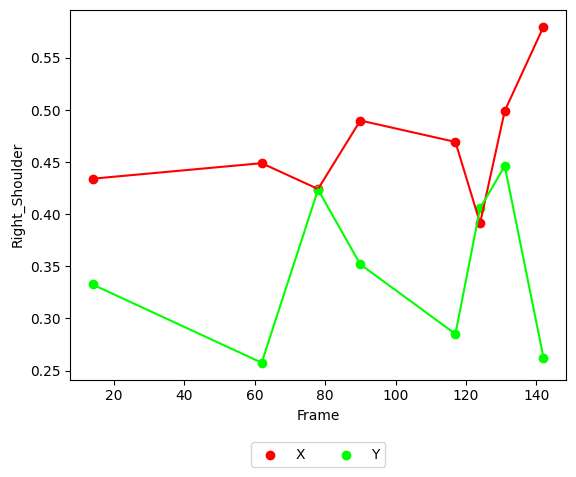

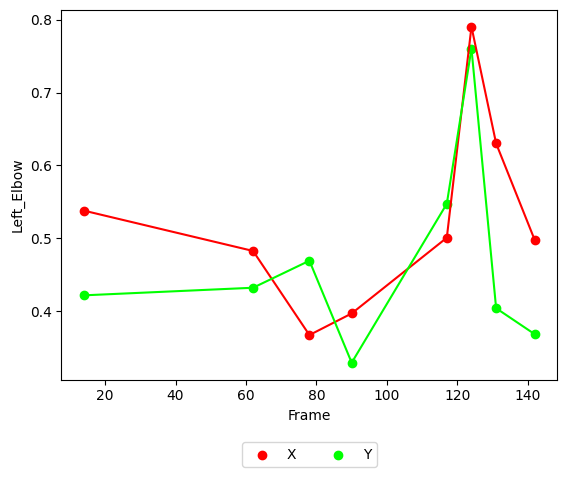

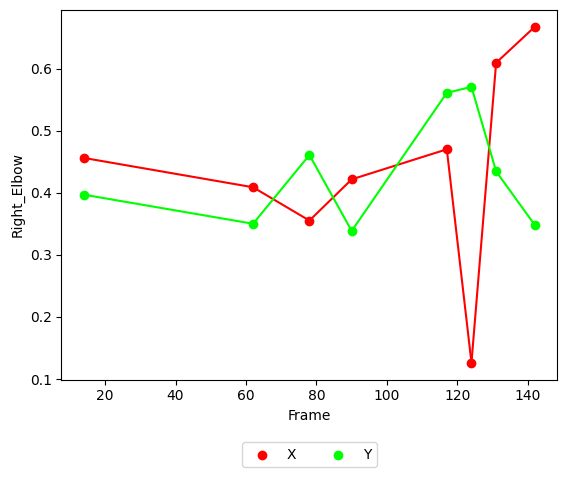

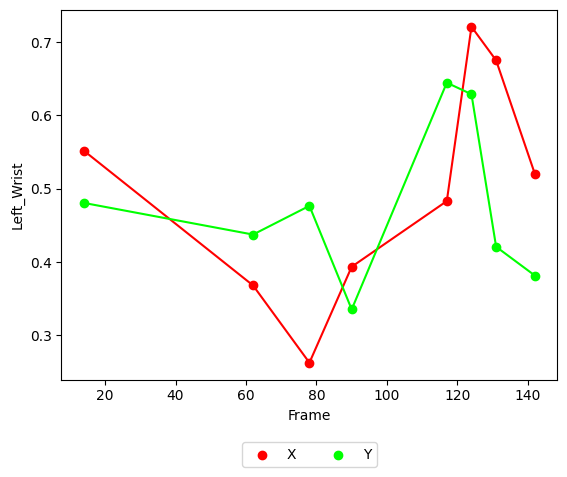

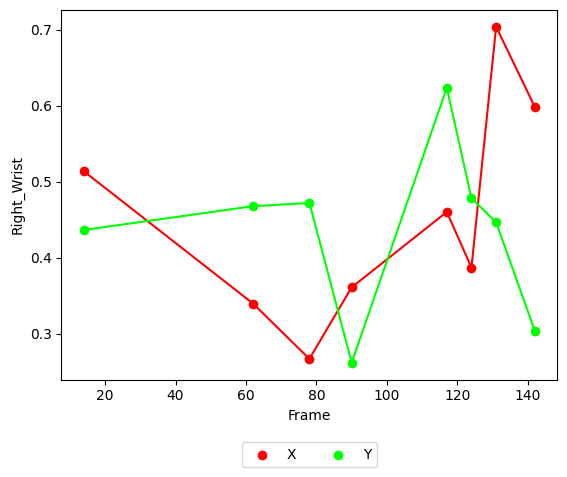

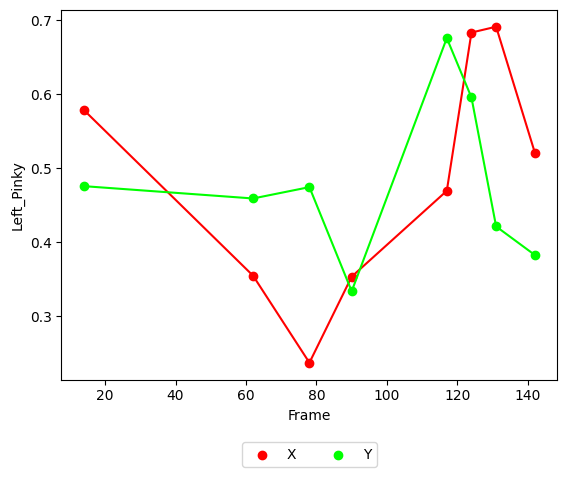

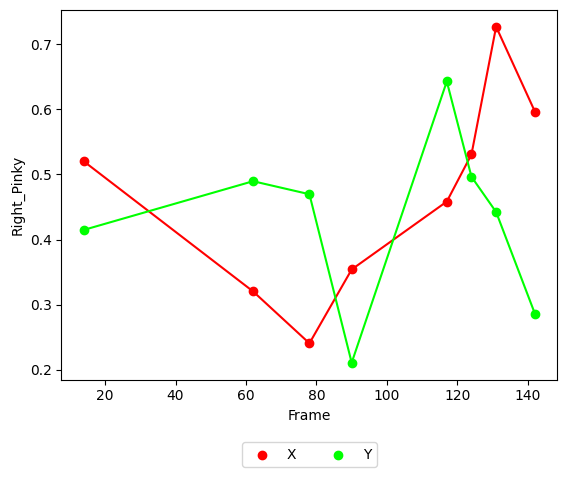

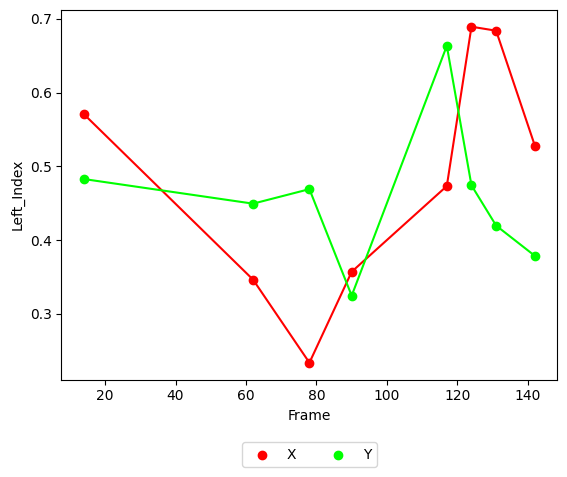

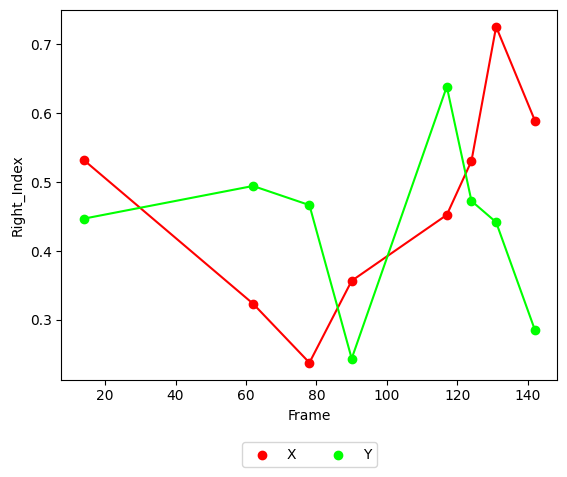

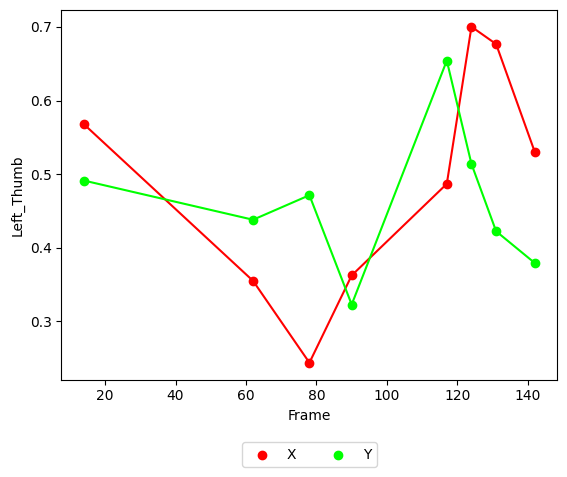

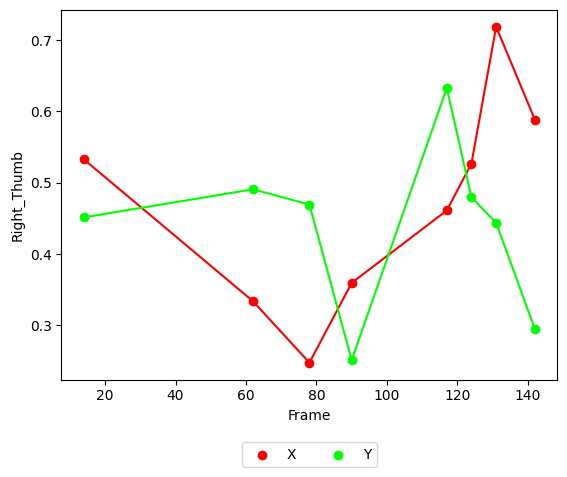

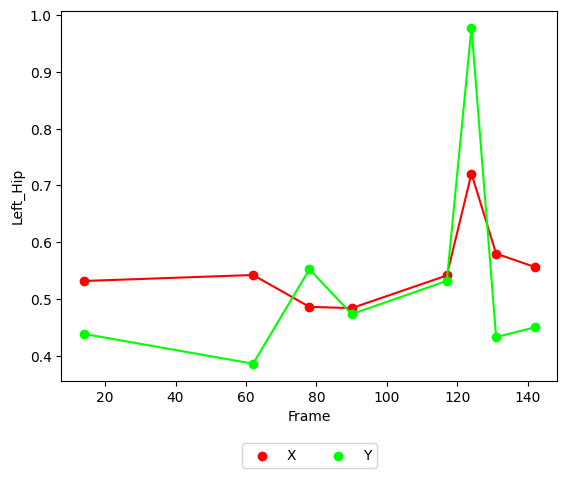

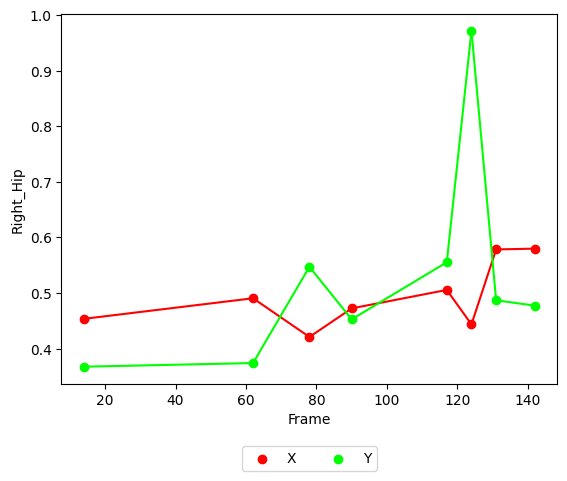

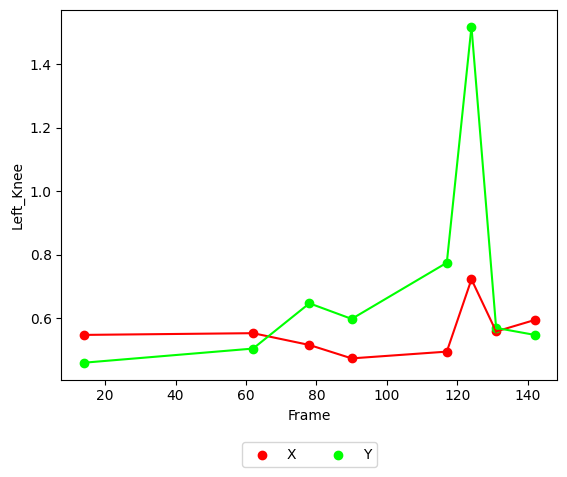

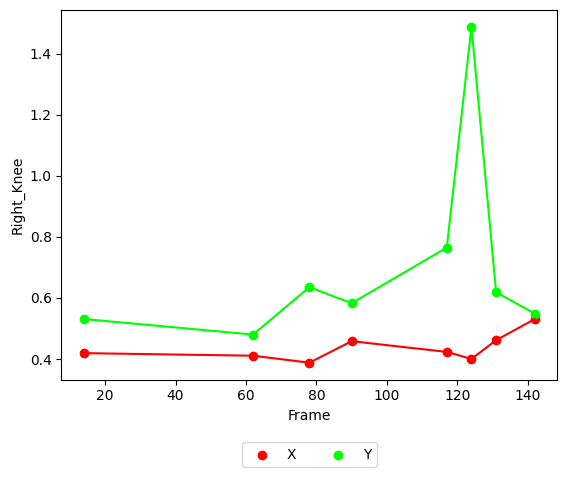

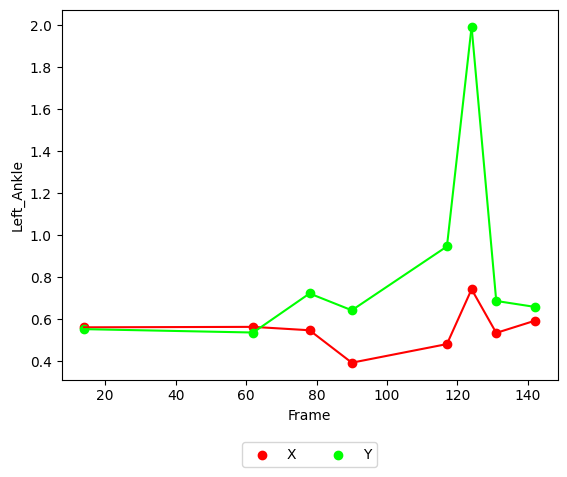

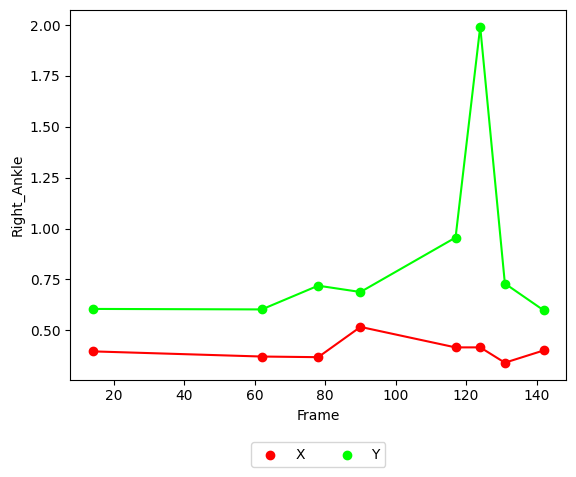

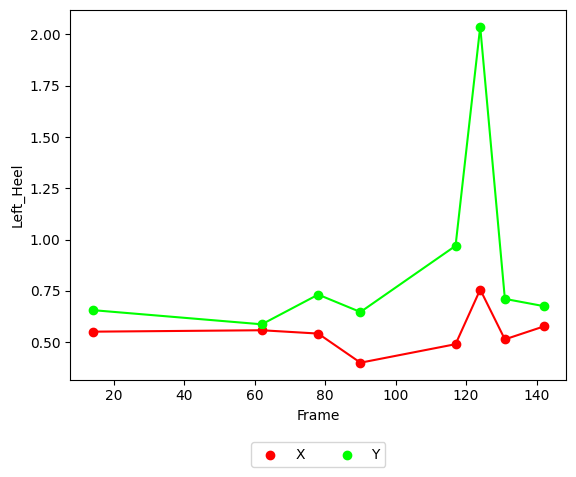

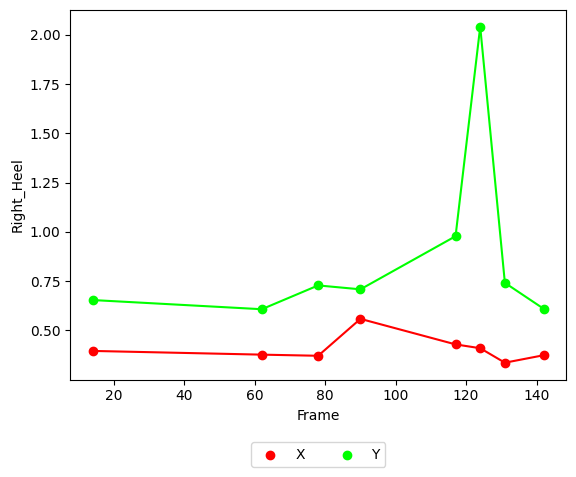

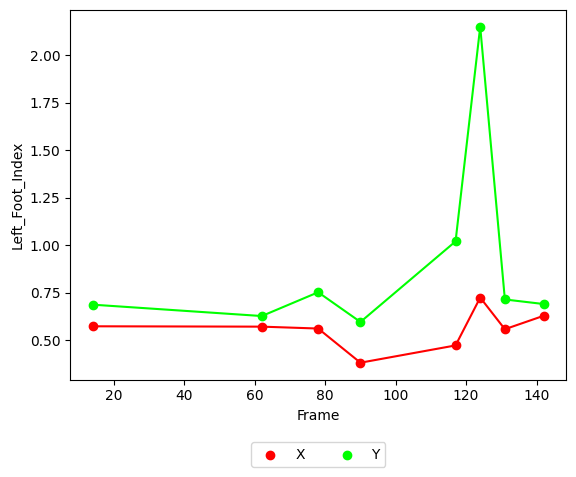

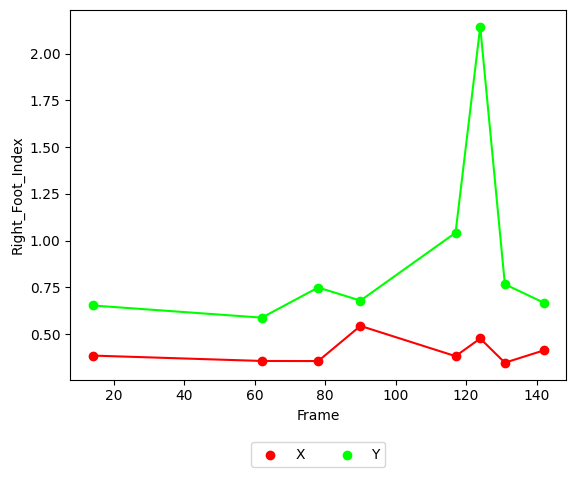

In [174]:
DISTINCT_COLORS_MODIFIED = [tuple((value / 255) for value in tuple_data) for tuple_data in DISTINCT_COLORS]
indep = events_lms_df.index.tolist()
for lm_int in mp_pose.PoseLandmark:
    counter = 0
    for char in XYZ:
        distinct_color = DISTINCT_COLORS_MODIFIED[counter]
        lm_str = lm_int_to_lm_str(lm_int)
        column_label = lm_str + '_' + char.capitalize() + '_Position'
        dep = events_lms_df[column_label].tolist()
        plt.scatter(indep, dep, color=distinct_color, label=char.capitalize())
        for i in range(len(indep) - 1):
            plt.plot([indep[i], indep[i+1]], [dep[i], dep[i+1]], color=distinct_color)
        counter += 1
    plt.xlabel('Frame')
    plt.ylabel(lm_str)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.show()

/var/folders/g1/yhkdxb7d5sx9jmzlmt0bgsvr0000gn/T/ipykernel_58327/4229658053.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()  # Adjust spacing between subplots


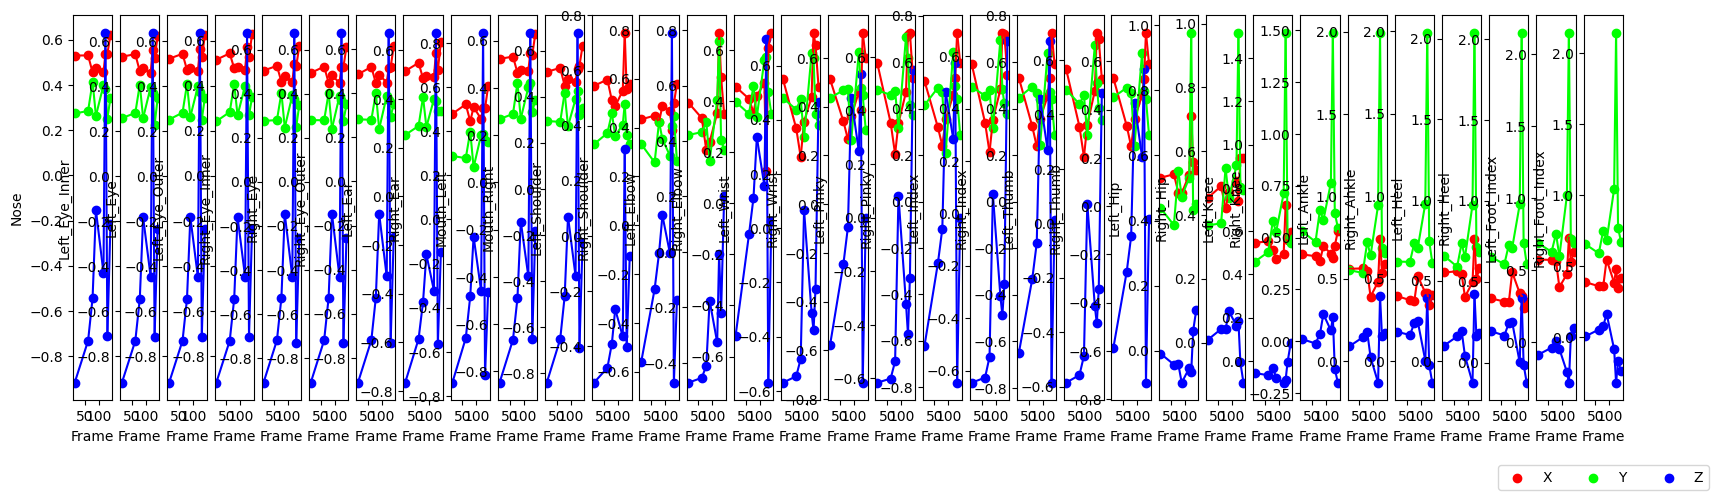

In [172]:
DISTINCT_COLORS_MODIFIED = [tuple((value / 255) for value in tuple_data) for tuple_data in DISTINCT_COLORS]
indep = events_lms_df.index.tolist()

fig, axs = plt.subplots(1, 33, figsize=(20, 5))  # Create a single row of 33 subplots

for ax, lm_int in zip(axs, mp_pose.PoseLandmark):
    counter = 0
    for char in XYZ:
        distinct_color = DISTINCT_COLORS_MODIFIED[counter]
        lm_str = lm_int_to_lm_str(lm_int)
        column_label = lm_str + '_' + char.capitalize() + '_Position'
        dep = events_lms_df[column_label].tolist()
        ax.scatter(indep, dep, color=distinct_color, label=char.capitalize())
        for i in range(len(indep) - 1):
            ax.plot([indep[i], indep[i+1]], [dep[i], dep[i+1]], color=distinct_color)
        counter += 1
    ax.set_xlabel('Frame')
    ax.set_ylabel(lm_str)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [72]:
###############
# NUMBER DATA #
###############

# Read Excel files.
# Note: Replace the directory paths with your own paths.
# Note: MacOS and Windows use different nomenclature; use escape sequences as needed.
swing_data = pd.read_excel('FT_All_Data/FT_Number_Data/DrivingRangeD.xlsx')
swing_data_pro = pd.read_excel('FT_All_Data/FT_Number_Data/ProSwingData.xlsx')
swing_videos = pd.read_excel('FT_All_Data/FT_Number_Data/SwingVideos.xlsx')

In [73]:
# Abbreviate the file variables.
sd0 = swing_data
sdp0 = swing_data_pro
sv0 = swing_videos

In [74]:
# Copy all the abbreviated file variables into the ones we will use.
sd = sd0.copy()
sdp = sdp0.copy()
sv = sv0.copy()

In [75]:
# Drop all rows that contain null or inf values.
sd.replace([np.inf, -np.inf], np.nan, inplace=True)
sdp.replace([np.inf, -np.inf], np.nan, inplace=True)
sv.replace([np.inf, -np.inf], np.nan, inplace=True)
sd.dropna(inplace=True)
sdp.dropna(inplace=True)
sv.dropna(inplace=True)

In [76]:
# Create a new df for all player and pro analyses.
ad = pd.DataFrame()
adp = pd.DataFrame()

In [77]:
# Add new columns 'Date' & 'Time' to 'ad' for standarized date and time.
sd['Date_And_Time'] = pd.to_datetime(sd['Date'], format='%m/%d/%Y %I:%M:%S %p')
ad['Date'] = sd['Date_And_Time'].dt.date
ad['Time'] = sd['Date_And_Time'].dt.time

In [78]:
# Add new columns 'Club_Type_Str' & 'Club_Type_Float' to 'adp' to identify club types.
adp['Club_Type_Str'] = sdp['Club']
adp['Club_Type_Float'] = adp['Club_Type_Str'].apply(ct_str_to_ct_float)
adp['Club_Type_Str'] = adp['Club_Type_Float'].apply(ct_float_to_ct_str)

In [79]:
# Add a new column 'Swing' to 'sd', 'ad', 'sdp', and 'adp' and set the index of all to that.
sd['Swing'] = range(1, len(sd) + 1)
sd.set_index('Swing', inplace=True)
ad['Swing'] = range(1, len(ad) + 1)
ad.set_index('Swing', inplace=True)
sdp['Swing'] = range(1, len(sdp) + 1)
sdp.set_index('Swing', inplace=True)
adp['Swing'] = range(1, len(adp) + 1)
adp.set_index('Swing', inplace=True)

In [80]:
# Add new columns 'Club_Type_Str' & 'Club_Type_Float' to 'ad' to identify club types.
ad['Club_Type_Str'] = sd['Club']
ad['Club_Type_Float'] = ad['Club_Type_Str'].apply(ct_str_to_ct_float)
ad['Club_Type_Str'] = ad['Club_Type_Float'].apply(ct_float_to_ct_str)

In [81]:
# Transfer all the 'x_labels'.
ad['Club_Speed'] = sd['Club_Speed']
ad['Attack_Angle'] = sd['Attack_Angle']
ad['Club_Path'] = sd['Club_Path']
ad['Low_Point'] = sd['Low_Point']
ad['Swing_Plane'] = sd['Swing_Plane']
ad['Swing_Direction'] = sd['Swing_Direction']
ad['Dynamic_Loft'] = sd['Dyn._Loft']
ad['Face_Angle'] = sd['Face_Angle']
ad['Face_To_Path'] = sd['Face_To_Path']
ad['Dynamic_Lie'] = sd['Dynamic_Lie']
ad['Impact_Offset'] = sd['Impact_Offset_mm']
ad['Impact_Height'] = sd['Impact_Height_mm']

In [82]:
# Transfer all the 'y_labels'.
ad['Accuracy'] = sd['Est_Total_Flat_Side']
ad['Distance'] = sd['Est._Total_Flat_Length']

In [83]:
# Assign the independent variables ('x_labels') and dependent variables ('y_labels').
x_labels = ['Club_Speed', 'Attack_Angle', 'Club_Path', 'Low_Point', 'Swing_Plane', 'Swing_Direction', 'Dynamic_Loft', 'Face_Angle', 'Face_To_Path', 'Dynamic_Lie', 
'Impact_Offset', 'Impact_Height']
y_labels = ['Accuracy', 'Distance']

In [84]:
# Address the multicollinear issue by getting rid of similar 'x_labels'.
df = ad[x_labels]
while (is_multicollinear(df)):
    x_labels.remove(highest_corr_sum_feature(df, x_labels))
    df = ad[x_labels]

In [85]:
# Sort the df based on ascending 'Club_Type_Float'.
ad.sort_values(by='Club_Type_Float', inplace=True)

In [87]:
# Split the df into training and testing datasets.
ad_train = pd.DataFrame()
ad_test = pd.DataFrame()
unique_cts = ad['Club_Type_Str'].unique()
for ct_str in unique_cts:
    club_df = ad.loc[ad['Club_Type_Str'] == ct_str]
    num_rows = len(club_df)
    midpoint = int(np.floor(num_rows * 0.8))
    club_train = club_df.iloc[:midpoint]
    club_test = club_df.iloc[midpoint:]
    ad_train = pd.concat([ad_train, club_train], axis=0)
    ad_test = pd.concat([ad_test, club_test], axis=0)

In [88]:
################
# CALCULATIONS #
################  

# Make a new df to store each club's information, set the index to the club types, and initialize the columns.
clubs_df = pd.DataFrame()
clubs_df['Club_Type_Str'] = pd.Series(unique_cts)
clubs_df.set_index('Club_Type_Str', inplace=True)
for y_label in y_labels:
    for x_label in x_labels:
        column_label = x_label + '_Predicted_' + y_label
        ad[column_label] = 0.0
        for i in range(1, 7):
            column_label = x_label + '_vs_' + y_label + '_' + str(i)
            clubs_df[column_label] = ''

In [89]:
# Calculate the correlation for each of the 'x_labels' against each of the 'y_labels' per 'Club_Type_Str' and store them into 'clubs_df'.
club_type_count = 0
club_type_counts = []
for ct_str in unique_cts:
    club_type_counts.append((ad['Club_Type_Str'] == ct_str).sum())
for ct_str in unique_cts:
    club_df = ad.loc[ad['Club_Type_Str'] == ct_str]
    for y_label in y_labels:
        y = club_df[y_label].values
        for x_label in x_labels:
            x = club_df[x_label].values
            for i in range(1, 7):
                column_label = x_label + '_vs_' + y_label + '_' + str(i)
                coefficients = np.polyfit(x, y, i)
                predicted_values = np.polyval(coefficients, x)
                clubs_df.at[ct_str, column_label] = 'Corr: ' + str(custom_round(pearsonr(y, predicted_values)[0], 3)) + ', P-value: ' + str(custom_round(pearsonr(y, predicted_values)[1], 3))
                if i == 6:
                    column_label = x_label + '_Predicted_' + y_label
                    if club_type_count == 0:
                        ad.iloc[0:club_type_counts[club_type_count], ad.columns.get_loc(column_label)] = pd.Series(predicted_values)
                    elif club_type_count < len(club_type_counts):
                        ad.iloc[sum(club_type_counts[:club_type_count]):sum(club_type_counts[:club_type_count+1]), ad.columns.get_loc(column_label)] = pd.Series(predicted_values)
                    else:
                        ad.iloc[sum(club_type_counts[:club_type_count]):len(ad), ad.columns.get_loc(column_label)] = pd.Series(predicted_values)
    club_type_count += 1

In [90]:
ad

Date      Time   Club_Type_Str  Club_Type_Float  Club_Speed  \
Swing                                                                      
268    2023-05-28  12:51:42          Driver              1.0   97.935308   
269    2023-05-28  12:51:07          Driver              1.0   94.320419   
180    2023-06-01  20:51:32          Driver              1.0   95.595472   
181    2023-06-01  20:50:57          Driver              1.0   93.031943   
182    2023-06-01  20:50:17          Driver              1.0   95.955619   
183    2023-06-01  20:49:34          Driver              1.0   95.993647   
184    2023-06-01  20:49:07          Driver              1.0   96.038386   
185    2023-06-01  20:48:30          Driver              1.0   95.799034   
270    2023-05-28  12:50:43          Driver              1.0   96.608805   
186    2023-06-01  20:47:57          Driver              1.0   95.852720   
188    2023-06-01  20:46:32          Driver              1.0   95.707319   
189    2023-06-01  20:46:04          Driver              1.0   96.725125   
190    2023-06-01  20:45:33          Driver              1.0   95.248747   
191    2023-06-01  20:45:05          Driver              1.0   96.333661   
192    2023-06-01  20:44:17          Driver              1.0   96.534986   
193    2023-06-01  20:43:44          Driver              1.0   95.931013   
194    2023-06-01  20:43:12          Driver              1.0   96.662491   
187    2023-06-01  20:47:29          Driver              1.0   95.226378   
271    2023-05-28  12:50:07          Driver              1.0   97.763064   
272    2023-05-28  12:49:42          Driver              1.0   92.792591   
273    2023-05-28  12:49:03          Driver              1.0   94.031854   
290    2023-05-28  12:37:33          Driver              1.0   97.172513   
289    2023-05-28  12:38:00          Driver              1.0   95.846009   
288    2023-05-28  12:38:25          Driver              1.0   96.599857   
287    2023-05-28  12:38:54          Driver              1.0   97.380548   
286    2023-05-28  12:39:17          Driver              1.0   97.483447   
285    2023-05-28  12:39:46          Driver              1.0   96.561829   
284    2023-05-28  12:40:58          Driver              1.0   94.714120   
283    2023-05-28  12:41:19          Driver              1.0   94.660433   
282    2023-05-28  12:41:39          Driver              1.0   96.183787   
281    2023-05-28  12:42:08          Driver              1.0   96.425376   
280    2023-05-28  12:42:39          Driver              1.0   97.029349   
279    2023-05-28  12:43:06          Driver              1.0   98.389406   
278    2023-05-28  12:43:32          Driver              1.0   94.767806   
277    2023-05-28  12:43:59          Driver              1.0   96.250895   
276    2023-05-28  12:44:29          Driver              1.0   96.485773   
275    2023-05-28  12:44:56          Driver              1.0   95.523890   
274    2023-05-28  12:48:37          Driver              1.0   92.638243   
195    2023-06-01  20:42:43          Driver              1.0   97.219488   
291    2023-05-28  12:36:46          Driver              1.0   94.197387   
196    2023-06-01  20:42:20          Driver              1.0   96.669202   
198    2023-06-01  20:41:06          Driver              1.0   95.087688   
220    2023-06-01  20:26:49          Driver              1.0   98.463225   
221    2023-06-01  20:26:22          Driver              1.0   93.801450   
222    2023-06-01  20:25:37          Driver              1.0   94.837151   
223    2023-06-01  20:25:01          Driver              1.0   96.861578   
224    2023-06-01  20:24:22          Driver              1.0   95.405333   
225    2023-06-01  20:23:24          Driver              1.0   96.640122   
226    2023-06-01  20:22:59          Driver              1.0   92.009664   
219    2023-06-01  20:27:49          Driver              1.0   96.029438   
258    2023-05-28  12:57:33          Driver              1.0 

In [22]:
# Calculate the condition number for each of the 'x_labels' vs. 'y_labels'.
for ct_str in unique_cts:
    club_df = ad.loc[ad['Club_Type_Str'] == ct_str]
    for y_label in y_labels:
        y = club_df[y_label].values
        for x_label in x_labels:
            x = club_df[x_label].values
            club_matrix = np.empty((0, 2))
            for i in range(0, len(x)):
                row = [x[i], y[i]]
                club_matrix = np.vstack([club_matrix, row])
            column_label = x_label + '_vs_' + y_label + '_Condition_Number'
            clubs_df.at[ct_str, column_label] = np.linalg.cond(club_matrix)

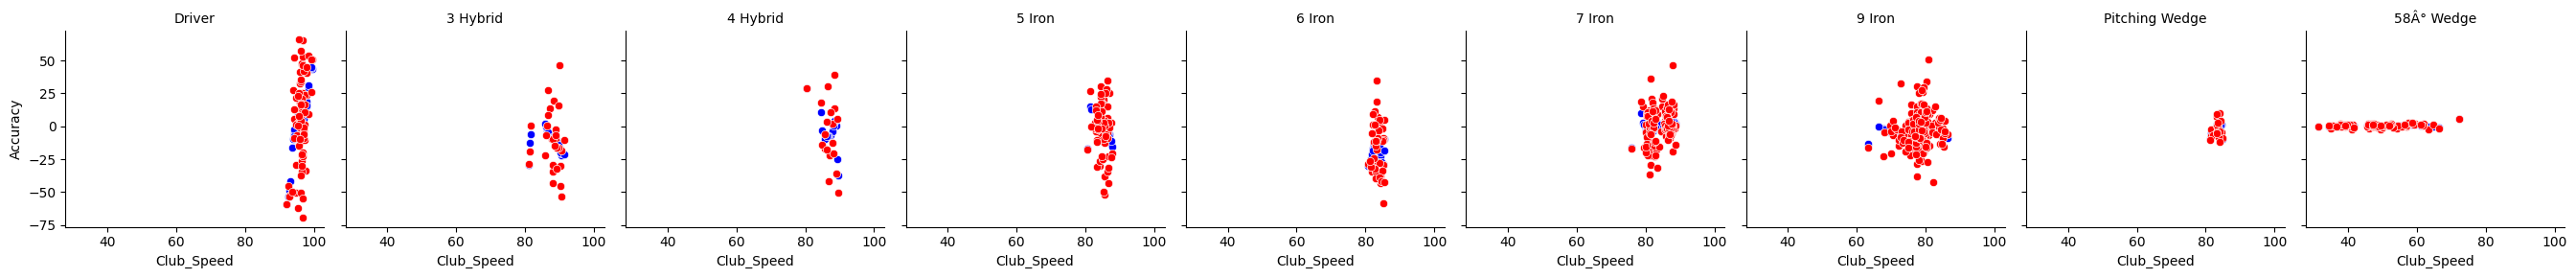

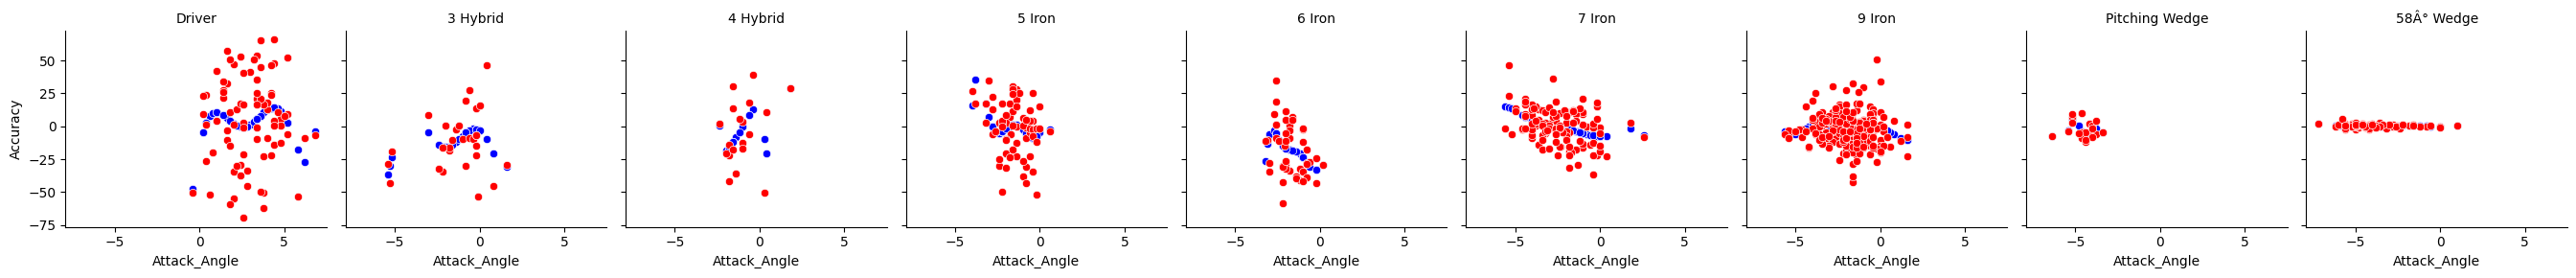

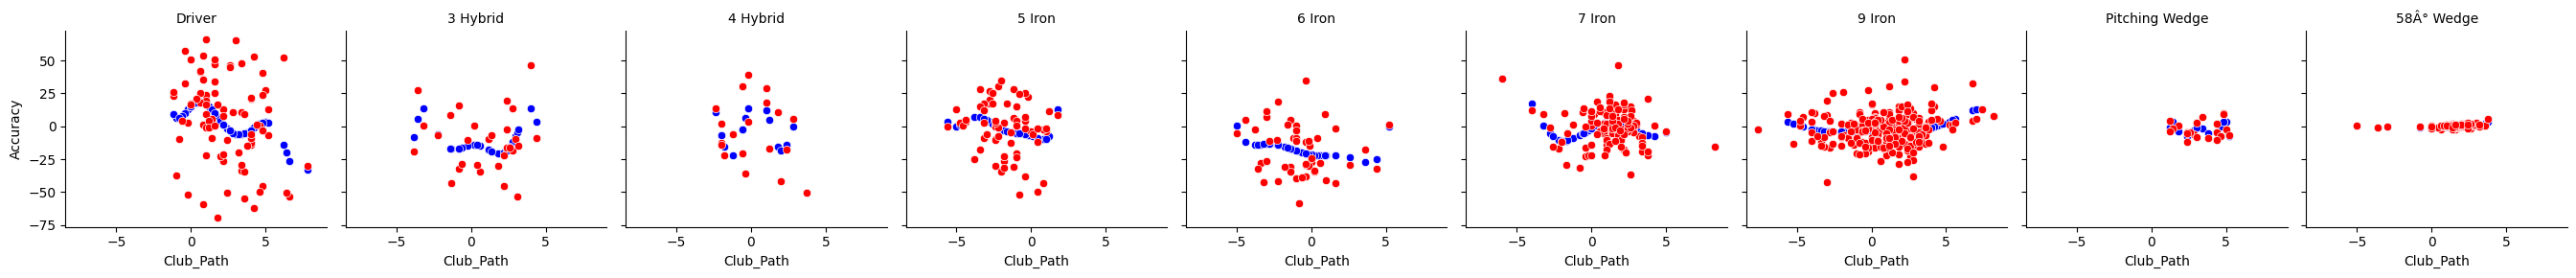

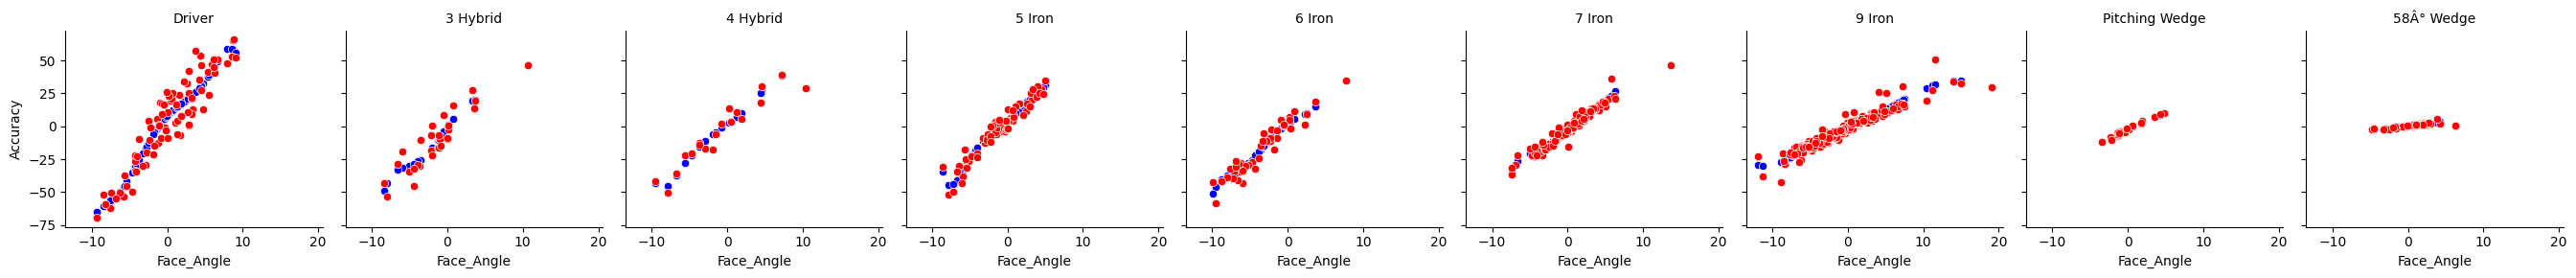

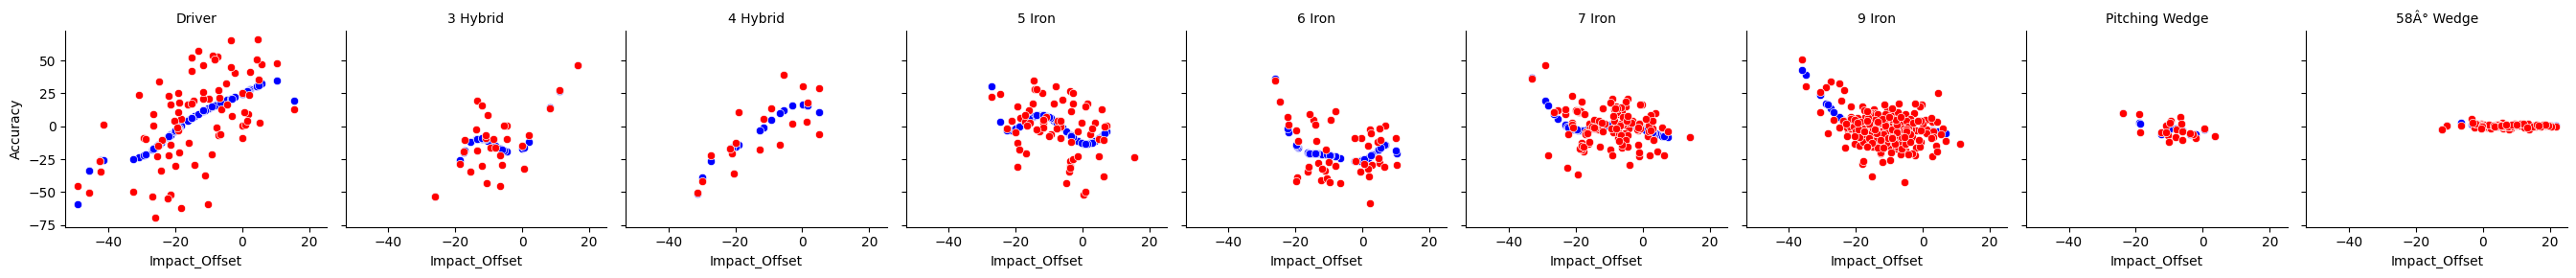

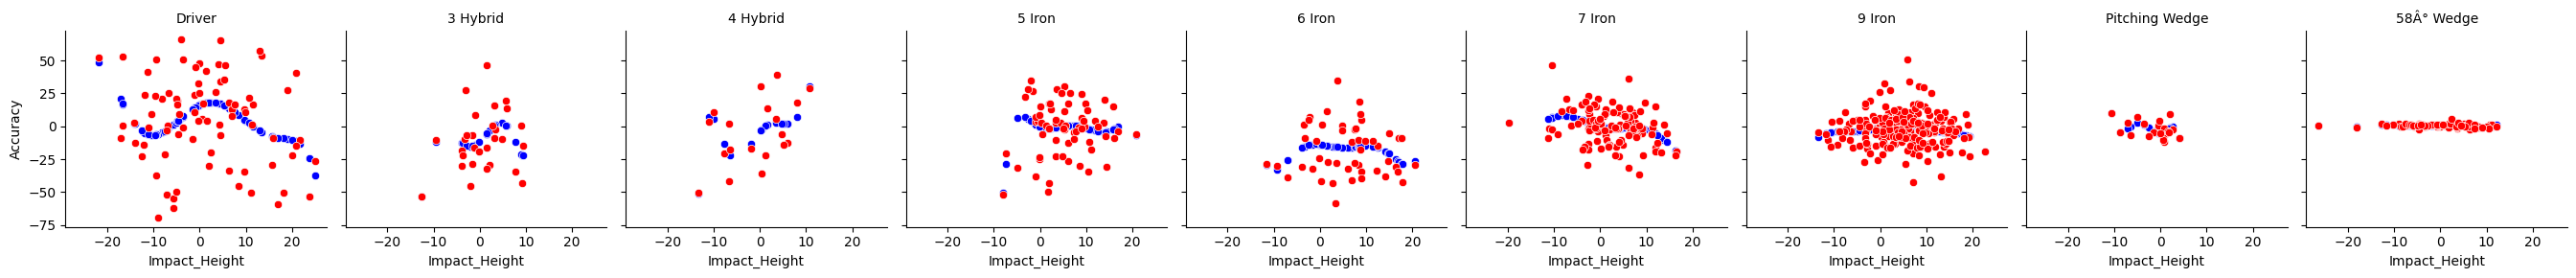

In [24]:
# Show facet grids for the 'x_labels' and 'Accuracy' ordered by 'Club_Type_Float'.
for x_label in x_labels:
    g = sns.FacetGrid(ad, col='Club_Type_Str')
    column_label = x_label + '_Predicted_Accuracy'
    g.map(sns.scatterplot, x_label, column_label, color='blue')
    g.map(sns.scatterplot, x_label, y_labels[0], color='red') # This is hard-coded as of now.
    g.set_titles(col_template='{col_name}')

In [ ]:
# Show facet grids for the 'x_labels' and 'Distance' ordered by 'Club_Type_Float'.
for x_label in x_labels:
    g = sns.FacetGrid(ad, col='Club_Type_Str')
    g.map(sns.scatterplot, x_label, y_labels[1]) # This is hard-coded as of now.
    g.set_titles(col_template='{col_name}')